# Batch Crystalliser in Pyomo: Model-based selection of experiments

Cameron Brown (cameron.brown.100@strath.ac.uk), Aaron Bjarnason (aaron.bjarnason@strath.ac.uk), Alex Dowling (adowling@nd.edu), Hailey Lynch (hlynch@nd.edu), Dan Laky (dlaky@nd.edu)


This file:
 1. Simulates crystallization experiments, and adds measurement noise to the data (prior data).
 2. Estimates the kinetic parameters using prior data (parmest).
 3. Considers a list of experiments and uses FIM to estimate which one might give most information about parameter set. 
 4. Iterates on this process: which experiment gives best (D-optimal) projected information content > Re-estimate parameter set > Remove completed experiment from list > Find new optimal experiment > Re-estimate...

 Requires files: 'Cryst_model_plot.py', 'Design of Experiments.xlsx'


## Setup Environment

In [1]:
# Imports

import sys

import numpy as np
import scipy
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
%matplotlib inline

import pandas as pd

import pyomo.environ as pyo
from pyomo.dae import *
from pyomo.contrib.doe import (ModelOptionLib, DesignOfExperiments, MeasurementVariables, DesignVariables)

# Function files - newly separated from main body
# from Cryst_model_MB_SoE import *
# from Cryst_model import *
from Cryst_model_plot import *
# from Cryst_model_parmest import *

from colorama import Fore, Back, Style

## Define Typical Experiment and Model

Now within Cryst_model.py

In [2]:
def typical_experiment(beta=0.1/60):
  '''
  This function defines a typical experiment for batch crystallization

  Outputs:
  exp_conditions: returns dictionary of experimental conditions
  '''
  # Empty dictionary for experimental condtions
  exp_conditions = {}

  # Experimental parameters (Ci, Ti, tau, beta, eps, M_seed, Ls)

  exp_conditions['Ci'] = 116.68 * 1e-3  # initial concentration [g.cm-3]
  #exp_conditions['Ci'] = 112.68 * 1e-3 # different option

  exp_conditions['Ti'] = 323.9          # initial temperature [K]

  exp_conditions['tau'] = 7200          # process duration [s]

  # exp_conditions['beta'] = 0         
  exp_conditions['beta'] = beta         # cooling rate [K/s]

  exp_conditions['eps'] = 0.5 * 1e-3    # power density [W / g cryst
  
  #   exp_conditions['M_seed'] = 2.4 * 1e-3     # initial seed concentration [g.cm-3]
  exp_conditions['M_seed'] = 0          # initial seed concentration [kg.m-3], [g.cm-3]

  exp_conditions['Ls'] = 2e-5 * 1e3     # seed size [mm]

  return exp_conditions


In [3]:
# Creating the model for simulations using theta_est
def model_theta_switch(mod=None, model_option='parmest', exp_conditions=typical_experiment(), time_points=None):
    '''
    Create a Concrete Pyomo model for the crystallization problem

    We are debugging this model now. For parameter estimation and MBDoE,
    this function will be very helpful.

    Inputs:
    mod: model; set to None
    model_option: model option; choose between stage1, stage2, parmest
    exp_conditions: experimental conditions
    time_points: time points; set to None

    Outputs:
    m: Pyomo model
    '''

    ## Build the model ##
    # m = pyo.ConcreteModel()
    m=mod

    ## Model option ##
    model_option = ModelOptionLib(model_option)

    if model_option == ModelOptionLib.parmest:
        m = pyo.ConcreteModel()
        #print('created model')
        return_m = True
    elif model_option == ModelOptionLib.stage1 or model_option == ModelOptionLib.stage2:
        if not mod:
            raise ValueError(
                "If model option is stage1 or stage2, a created model needs to be provided."
            )
        return_m = False
    else:
        raise ValueError(
            "model_option needs to be defined as parmest, stage1, or stage2."
        )

    ## Fixed parameters ##

    # These parameters are not changing
    rho     = 1360 * 1e-6       # crystal density [g.mm-3]
    kv      = 0.523             # volume shape factor
    C1      = 2.209e-6 * 1e-3   # solubility parameter 1 (for g.cm-3)
    C2      = 5.419e-2          # solubility parameter 2

    # Establishing non-dimensional time parameter (i.e., t=tau*t_f)
    m.tau = exp_conditions['tau']

    ## Scaling parameters ##
    m.mu0_scale      = 1e5
    m.mu1_scale      = 1e4
    m.mu2_scale      = 1e2
    m.mu3_scale      = 1e1
    m.mu4_scale      = 1e0
    # m.B_scale        = 1e1
    # m.B_scale        = 1e2  # May change this back
    m.Bp_scale       = 1e1  # Primary nucl. scaling
    m.Bs_scale       = 1e2  # Seconday nucl. scaling
    m.G_scale        = 1e-5

    ## Fitting parameters ##
    # These are the parameters we are using for parameter estimation
    if expt_selection == True:  # Use estimated parameter set
        if theta_est is not None:
            m.theta = theta_est # If we have previous values for theta^
        else:                   # Initial guess
            m.theta = {'kg': 3e-4, 'g': 1}
    else:                       # Use true parameter values: experimental data
        m.theta     = {'kg': 2e-4, 'g': 1} # kb1 to unit 1/mL, kb2 does not have units changed due to balance on epsilon units, kg changed to mm/s. Unit conversions added

    ## Time ##
    m.t0 = pyo.Set(initialize=[0]) # Initial time
    if time_points is not None:
        # Do not specify time points
        # m.t = ContinuousSet(bounds=(0, 1)) # Time set
        m.t = ContinuousSet(bounds=(0, m.tau)) # Time set
    else:
        # m.t = ContinuousSet(bounds=(0, 1), initialize=time_points) # Time set
        m.t = ContinuousSet(bounds=(0, m.tau), initialize=time_points) # Time set

    ## Initial Conditions ##
    # Declare data used for only initial conditions

    c_sat = 1.01*C1*np.exp(C2*exp_conditions['Ti'])

    # Concentration
    m.Ci = pyo.Param(m.t0, initialize = exp_conditions['Ci'], within = pyo.NonNegativeReals)
    # m.Ci = pyo.Var(m.t0, initialize=c_sat, within=pyo.NonNegativeReals)

    # Temperature
    # m.Ti = pyo.Param(m.t0, initialize = exp_conditions['Ti'], within = pyo.NonNegativeReals)
    m.Ti = pyo.Var(m.t0, initialize = exp_conditions['Ti'], within = pyo.NonNegativeReals)

    # Epsilon
    m.eps = pyo.Param(m.t0, initialize = exp_conditions['eps'], within = pyo.NonNegativeReals)

    # M seed
    # m.M_seed = pyo.Param(m.t0, initialize = exp_conditions['M_seed'], within = pyo.NonNegativeReals)
    m.M_seed = pyo.Var(m.t0, initialize = exp_conditions['M_seed'], within = pyo.NonNegativeReals)

    # Ls
    m.Ls = pyo.Param(m.t0, initialize = exp_conditions['Ls'], within = pyo.NonNegativeReals)

    # Beta
    # For now, assume constant scaling
    m.beta = pyo.Var(m.t0, initialize = exp_conditions['beta'], within = pyo.NonNegativeReals)

    ## Declare pyo.Variables ##
    # m.mu0 = pyo.Var(m.t, initialize = 0, within = pyo.NonNegativeReals)
    m.mu0 = pyo.Var(m.t, initialize = exp_conditions['M_seed']/(rho*kv*exp_conditions['Ls']**3)/m.mu0_scale, within = pyo.NonNegativeReals)
    # m.mu1 = pyo.Var(m.t, initialize = 0, within = pyo.NonNegativeReals)
    m.mu1 = pyo.Var(m.t, initialize = exp_conditions['M_seed']/(rho*kv*exp_conditions['Ls']**4)/m.mu1_scale, within = pyo.NonNegativeReals)
    # m.mu2 = pyo.Var(m.t, initialize = 0, within = pyo.NonNegativeReals)
    m.mu2 = pyo.Var(m.t, initialize = exp_conditions['M_seed']/(rho*kv*exp_conditions['Ls']**5)/m.mu2_scale, within = pyo.NonNegativeReals)
    # m.mu3 = pyo.Var(m.t, initialize = 0, within = pyo.NonNegativeReals)
    m.mu3 = pyo.Var(m.t, initialize = exp_conditions['M_seed']/(rho*kv*exp_conditions['Ls']**6)/m.mu3_scale, within = pyo.NonNegativeReals)
    # m.mu4 = pyo.Var(m.t, initialize = 0, within = pyo.NonNegativeReals)
    m.mu4 = pyo.Var(m.t, initialize = exp_conditions['M_seed']/(rho*kv*exp_conditions['Ls']**7)/m.mu4_scale, within = pyo.NonNegativeReals)

    m.C     = pyo.Var(m.t, initialize = exp_conditions['Ci'],       within = pyo.NonNegativeReals)
    m.MT    = pyo.Var(m.t, initialize = exp_conditions['M_seed'],   within = pyo.NonNegativeReals)
    m.T     = pyo.Var(m.t, initialize = exp_conditions['Ti'],       within = pyo.NonNegativeReals)
    m.G     = pyo.Var(m.t, initialize = 0, within = pyo.NonNegativeReals)
    # m.B = pyo.Var(m.t, initialize = 0, within = pyo.NonNegativeReals)
    m.Bp    = pyo.Var(m.t, initialize = 0, within = pyo.NonNegativeReals)
    m.Bs    = pyo.Var(m.t, initialize = 0, within = pyo.NonNegativeReals)
    # m.avg_vol = pyo.Var(m.t, initialize=1, within=pyo.NonNegativeReals)
    m.avg_vol = pyo.Var(m.t, initialize=exp_conditions['Ls'], within=pyo.NonNegativeReals)

    ## Declare Derivative Variable ##
    m.dmu0 = DerivativeVar(m.mu0)
    m.dmu1 = DerivativeVar(m.mu1)
    m.dmu2 = DerivativeVar(m.mu2)
    m.dmu3 = DerivativeVar(m.mu3)
    m.dmu4 = DerivativeVar(m.mu4)
    m.dC   = DerivativeVar(m.C)
    m.dMT  = DerivativeVar(m.MT)  # --> don't need a DAE, just an algebraic eqn (?)
    m.dT   = DerivativeVar(m.T)


    '''
    m.kb1 = pyo.Param(initialize = m.theta['kb1'], mutable = True)
    m.b1  = pyo.Param(initialize = m.theta['b1'], mutable = True)
    m.kb2 = pyo.Param(initialize = m.theta['kb2'], mutable = True)
    m.b2  = pyo.Param(initialize = m.theta['b2'], mutable = True)
    m.kg  = pyo.Param(initialize = m.theta['kg'], mutable = True)
    m.g   = pyo.Param(initialize = m.theta['g'], mutable = True)
    '''
    ## Bounds ##
    low_b = 0.1
    high_b = 10

    ## New Bounds ##
    # m.theta_lb = {'kb1': 1e1, 'b1': 1, 'kb2': 1e6, 'b2': 1, 'kg': 2e-6, 'g': 1}
    m.theta_lb = {'kg': 1e-6, 'g': 1}     # PARAMETER SEARCH RANGE
    # m.theta_ub = {'kb1': 1e4, 'b1': 4, 'kb2': 1e12, 'b2': 5, 'kg': 2e-2, 'g': 3}
    m.theta_ub = {'kg': 1e-2, 'g': 3}     # PARAMETER SEARCH RANGE


    kb1_err     = 1     #True values for experimental 'measurements'
    b1_err      = 1
    kb2_err     = 1
    b2_err      = 1


    # m.kb1 = pyo.Var(initialize = m.theta['kb1'], bounds=(m.theta_lb['kb1'], m.theta_ub['kb1']))
    m.b1 = 1 * b1_err
    # m.kb2 = pyo.Var(initialize = m.theta['kb2'], bounds=(m.theta_lb['kb2'], m.theta_ub['kb2']))
    m.b2 = 2 * b2_err
    # m.kg = pyo.Var(initialize = m.theta['kg'], bounds=(m.theta_lb['kg'], m.theta_ub['kg']))
    m.g  = pyo.Var(initialize = m.theta['g'], bounds=(m.theta_lb['g'], m.theta_ub['g']))

    ## TRYING TO USE LOG TRANSFORMATION FOR K VALUES ##
    # m.kb1 = pyo.Var(initialize = np.log(m.theta['kb1']), bounds=(np.log(m.theta_lb['kb1']), np.log(m.theta_ub['kb1'])))
    m.kb1 = np.log(1e2 * kb1_err)
    m.kb2 = np.log(1e9 * kb2_err)
    m.kg  = pyo.Var(initialize = np.log(m.theta['kg']), bounds=(np.log(m.theta_lb['kg']),   np.log(m.theta_ub['kg'])))

    ## Fixing the parameters ##
    # m.kb1.fix()
    # m.b1.fix()
    # m.kb2.fix()
    # m.b2.fix()
    m.kg.fix()
    m.g.fix()

    alt_rel_sat = True

    ## Functions and Constraints ##
    # Smoothing function for undersaturated
    # (1/2)(sqrt(z^2 + eps) + z)
    # For undersaturation, let z = -M
    # M + (-M) --> 0
    # For supersaturation, let z = M
    # M + M --> (1/2)*(2M) --> M
    # trying to max(0,z) and returns z if > 0
    def smooth_max(z):
        return 0.5*(pyo.sqrt(z**2+1e-8)+z)

    # Solubility expression
    def solubility(T):
        return C1*pyo.exp(C2*T)

    def inv_solubility(T):
        return pyo.exp(-C2*T)/C1

    # Nucleation and growth expressions
    # @m.Constraint(m.t)
    # def nucleation(m, t):
    #     # Relative supersaturation computation
    #     rel_sat = (m.C[t] - solubility(m.T[t]))/solubility(m.T[t])
    #     # Total nucleation rate
    #     #        B    =             Primary                 +                       Secondary
    #     return m.B[t] == ((m.kb1*smooth_max(rel_sat)**m.b1) + (m.kb2*smooth_max(rel_sat)**m.b2)*m.eps[0]*(m.MT[t])) / m.B_scale

    # Primary and Secondary nucleation separated (for scaling purposes)
    @m.Constraint(m.t)
    def prim_nucl(m, t):
        # Relative supersaturation computation
        if alt_rel_sat:
            rel_sat = m.C[t]*inv_solubility(m.T[t])-1
        else:
            rel_sat = (m.C[t] - solubility(m.T[t]))/solubility(m.T[t])

        # return m.Bp[t] == (m.kb1*smooth_max(rel_sat)**m.b1) / m.Bp_scale
        return m.Bp[t] == (pyo.exp(m.kb1)*smooth_max(rel_sat)**m.b1) / m.Bp_scale

    @m.Constraint(m.t)
    def sec_nucl(m, t):
        # Relative supersaturation computation
        if alt_rel_sat:
            rel_sat = m.C[t]*inv_solubility(m.T[t])-1
        else:
            rel_sat = (m.C[t] - solubility(m.T[t]))/solubility(m.T[t])

        # return m.Bs[t] == (m.kb2*smooth_max(rel_sat)**m.b2)*m.eps[0]*(m.MT[t]) / m.Bs_scale
        return m.Bs[t] == (pyo.exp(m.kb2)*smooth_max(rel_sat)**m.b2)*m.eps[0]*(smooth_max(m.MT[t])) / m.Bs_scale


    @m.Constraint(m.t)
    def growth(m, t):
        # Relative supersaturation computation
        if alt_rel_sat:
            rel_sat = m.C[t]*inv_solubility(m.T[t])-1
        else:
            rel_sat = (m.C[t] - solubility(m.T[t]))/solubility(m.T[t])
        # Growth rate expression
        # return m.G[t] == (m.kg*smooth_max(rel_sat)**m.g) / m.G_scale
        return m.G[t] == (pyo.exp(m.kg)*smooth_max(rel_sat)**m.g) / m.G_scale


    # Constraints for moments and concentration (fixed) for units of mm (L) and mL, or cm^3 (V)
    # @m.Constraint(m.t)
    # def ode1(m, t):
    #     return m.dmu0[t] == m.B[t] * m.B_scale / m.mu0_scale #* m.tau  # Units of # / cm^3 / s

    @m.Constraint(m.t)
    def ode1(m, t):
        return m.dmu0[t] == (m.Bp[t] * m.Bp_scale + m.Bs[t] * m.Bs_scale) / m.mu0_scale #* m.tau  # Units of # / cm^3 / s

    @m.Constraint(m.t)
    def ode2(m, t):
        return m.dmu1[t] == m.G[t] * m.G_scale * m.mu0[t] * m.mu0_scale / m.mu1_scale #* m.tau  # Units of mm * # / cm^3 / s

    @m.Constraint(m.t)
    def ode3(m, t):
        return m.dmu2[t] == 2 * m.G[t] * m.G_scale * m.mu1[t] * m.mu1_scale / m.mu2_scale #* m.tau  # Units of mm^2 * # / cm^3 / s

    @m.Constraint(m.t)
    def ode4(m, t):
        return m.dmu3[t] == 3 * m.G[t] * m.G_scale * m.mu2[t] * m.mu2_scale / m.mu3_scale #* m.tau  # Units of mm^3 * # / cm^3 / s

    @m.Constraint(m.t)
    def ode5(m, t):
        return m.dmu4[t] == 4 * m.G[t] * m.G_scale * m.mu3[t] * m.mu3_scale / m.mu4_scale #* m.tau  # Units of mm^4 * # / cm^3 / s

    @m.Constraint(m.t)
    def ode6(m, t):
        return m.dC[t] == -3 * kv * rho * m.G[t] * m.G_scale * smooth_max(m.mu2[t]) * m.mu2_scale #* m.tau  # Units of g / cm^3 / s

    # @m.Constraint(m.t)
    # def MT_balance(m, t):
    #     return m.MT[t] == rho * kv * m.mu3[t] * m.mu3_scale # Units of grams.mm-3

    @m.Constraint(m.t)
    def ode7(m, t):
        return m.dMT[t] == 3 * kv * rho * m.G[t] * m.G_scale * smooth_max(m.mu2[t]) * m.mu2_scale # Units of grams.mm-3

    @m.Constraint(m.t)
    def ode8(m, t):
        return m.dT[t] == -m.beta[0] # * m.tau
        # beta[0] is 0 (temperature decay), if we set it to something else we will get something else
        # change beta 0 to something physical
        # (0,(0.5/60))

    @m.Constraint(m.t)
    def average_volume(m,t):
        return (m.mu4[t] + 1e-8) * m.mu4_scale == m.avg_vol[t] * (m.mu3[t] + 1e-8) * m.mu3_scale  # / 1000    Multiplying by 1000 to get in micrometers????
        # return (m.mu1[t] + 1e-8) * m.mu1_scale == m.avg_vol[t] * (m.mu0[t] + 1e-8) * m.mu0_scale


    ## Initial conditions (fixed), in units desired (mm and cm^3) ##
    m.mu0[0.0].fix(m.M_seed[0]/(rho*kv*m.Ls[0]**3)/m.mu0_scale)
    m.mu1[0.0].fix(m.mu0[0.0]*m.mu0_scale*m.Ls[0]/(m.mu1_scale))
    m.mu2[0.0].fix(m.mu0[0.0]*m.mu0_scale*(m.Ls[0])**2/m.mu2_scale)
    m.mu3[0.0].fix(m.mu0[0.0]*m.mu0_scale*(m.Ls[0])**3/m.mu3_scale)
    m.mu4[0.0].fix(m.mu0[0.0]*m.mu0_scale*(m.Ls[0])**4/m.mu4_scale)

    m.C[0.0].fix(m.Ci[0])
    m.MT[0.0].fix(m.M_seed[0])
    m.T[0].fix(m.Ti[0])

    ## Now fix the cooling rate ##
    m.beta[0].fix(exp_conditions['beta'])

    # Control time points
    # t_control = [0]
    # m.t_con = pyo.Set(initialize=t_control)

    if return_m:
      return m


# exp = typical_experiment_soe()

In [4]:
expt_selection = False  # Use 'true' parameter values
m = model_theta_switch(exp_conditions=typical_experiment())
# typical_experiment_soe()
print(typical_experiment())

{'Ci': 0.11668, 'Ti': 323.9, 'tau': 7200, 'beta': 0.0016666666666666668, 'eps': 0.0005, 'M_seed': 0, 'Ls': 0.02}


### Simulate Model

Now, simulate the model.

In [5]:
# Specify integrator options
int_ops = {'print_stats':True}

# Solve using simulator
sim = Simulator(m, package='casadi')
tsim, profiles = sim.simulate(numpoints=100, integrator = 'idas', integrator_options=int_ops)

FORWARD INTEGRATION:
Number of steps taken by SUNDIALS: 780
Number of calls to the user's f function: 1431
Number of calls made to the linear solver setup function: 137
Number of error test failures: 53
Method order used on the last internal step: 3
Method order to be used on the next internal step: 3
Actual value of initial step size: 6.28249e-05
Step size taken on the last internal step: 73.6149
Step size to be attempted on the next internal step: 147.23
Current internal time reached: 7200
Number of nonlinear iterations performed: 1429
Number of nonlinear convergence failures: 0



CasADi - 2024-05-27 13:52:27 WARNING("The options 't0', 'tf', 'grid' and 'output_t0' have been deprecated.
The same functionality is provided by providing additional input arguments to the 'integrator' function, in particular:
 * Call integrator(..., t0, tf, options) for a single output time, or
 * Call integrator(..., t0, grid, options) for multiple grid points.
The legacy 'output_t0' option can be emulated by including or excluding 't0' in 'grid'.
Backwards compatibility is provided in this release only.") [.../casadi/core/integrator.cpp:515]


## Plot Results

Plot function now in cryst_model_plot.py

### Simulator results

[   0.           72.72727273  145.45454545  218.18181818  290.90909091
  363.63636364  436.36363636  509.09090909  581.81818182  654.54545455
  727.27272727  800.          872.72727273  945.45454545 1018.18181818
 1090.90909091 1163.63636364 1236.36363636 1309.09090909 1381.81818182
 1454.54545455 1527.27272727 1600.         1672.72727273 1745.45454545
 1818.18181818 1890.90909091 1963.63636364 2036.36363636 2109.09090909
 2181.81818182 2254.54545455 2327.27272727 2400.         2472.72727273
 2545.45454545 2618.18181818 2690.90909091 2763.63636364 2836.36363636
 2909.09090909 2981.81818182 3054.54545455 3127.27272727 3200.
 3272.72727273 3345.45454545 3418.18181818 3490.90909091 3563.63636364
 3636.36363636 3709.09090909 3781.81818182 3854.54545455 3927.27272727
 4000.         4072.72727273 4145.45454545 4218.18181818 4290.90909091
 4363.63636364 4436.36363636 4509.09090909 4581.81818182 4654.54545455
 4727.27272727 4800.         4872.72727273 4945.45454545 5018.18181818
 5090.90909091

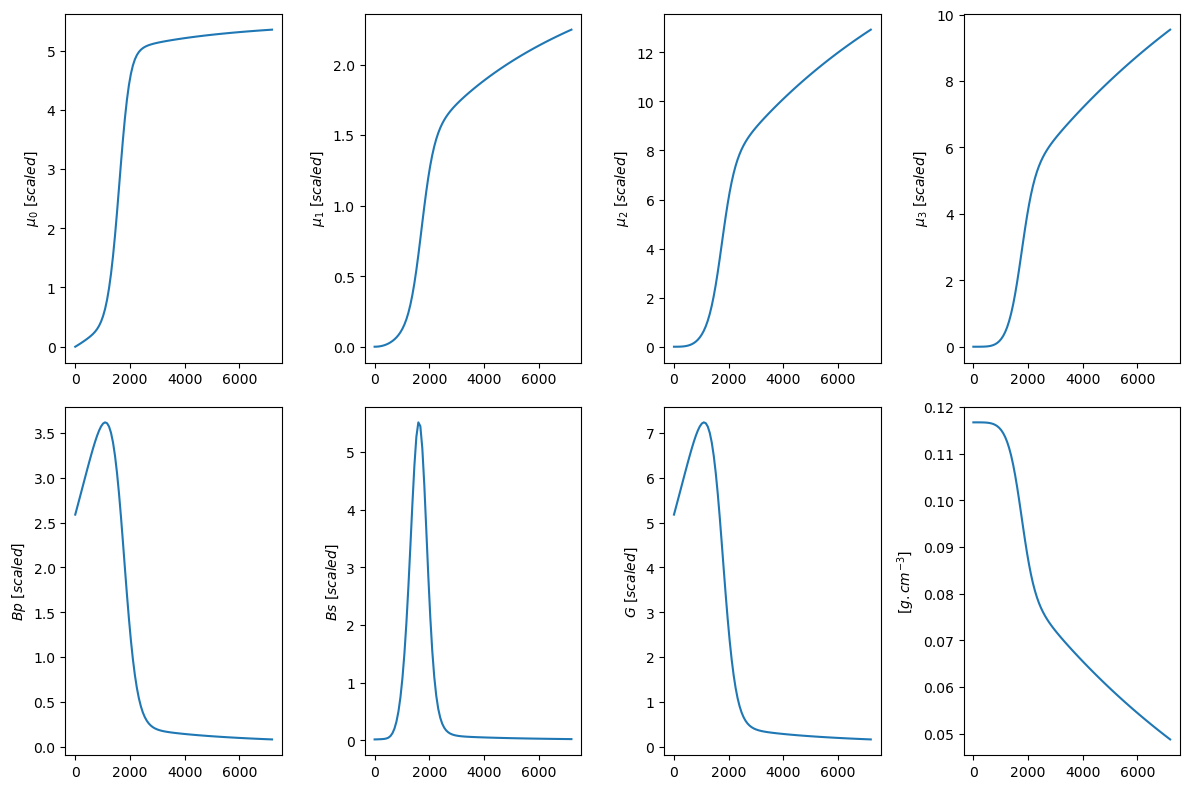

In [6]:
# Simulate results
sim_results = Results(m)
sim_results.load_from_simulator(tsim,profiles)
sim_results.plot(undo_scaling=False)

df = sim_results.to_pandas()

### Temperature profile testing

In [7]:
# Temperature profile testing
Ti      = 323.9     # initial temperature [K]
Te      = 293       # final temperature [K]
n       = 6         # cooling profile order [-]

# Small experiment with Pyomo.DAE
'''
m = pyo.ConcreteModel()

m.t = ContinuousSet(bounds=(0, tau))

m.T = pyo.Var(m.t, initialize = Ti, within = pyo.NonNegativeReals)
# m.mu0 = pyo.Var(m.t, initialize = 0, within = pyo.NonNegativeReals)
# m.dmu0 = DerivativeVar(m.mu0)

@m.Constraint(m.t)
def temperature(m, t):
    return m.T[t] == Ti - (Ti - Te)*(t / tau)**n

# @m.Constraint(m.t)
# def ode1(m, t):
#     return m.dmu0[t] == 1e12

# m.mu0[0.0].fix(0)


pyo.TransformationFactory('dae.finite_difference').apply_to(m, nfe=20, scheme='BACKWARD')

pyo.SolverFactory('ipopt').solve(m)

t_values = [t for t in m.t]
# mu0_values = [m.mu0[t]() for t in m.t]
T_values = [m.T[t]() for t in m.t]

plt.plot(t_values, T_values)
plt.show()

'''

"\nm = pyo.ConcreteModel()\n\nm.t = ContinuousSet(bounds=(0, tau))\n\nm.T = pyo.Var(m.t, initialize = Ti, within = pyo.NonNegativeReals)\n# m.mu0 = pyo.Var(m.t, initialize = 0, within = pyo.NonNegativeReals)\n# m.dmu0 = DerivativeVar(m.mu0)\n\n@m.Constraint(m.t)\ndef temperature(m, t):\n    return m.T[t] == Ti - (Ti - Te)*(t / tau)**n\n\n# @m.Constraint(m.t)\n# def ode1(m, t):\n#     return m.dmu0[t] == 1e12\n\n# m.mu0[0.0].fix(0)\n\n\npyo.TransformationFactory('dae.finite_difference').apply_to(m, nfe=20, scheme='BACKWARD')\n\npyo.SolverFactory('ipopt').solve(m)\n\nt_values = [t for t in m.t]\n# mu0_values = [m.mu0[t]() for t in m.t]\nT_values = [m.T[t]() for t in m.t]\n\nplt.plot(t_values, T_values)\nplt.show()\n\n"

## Numerical Integration with Ipopt

### Discretize

In [8]:
# Discretization using finite difference
# Add an objective. This is helpful for Degeneracy Hunter
m.obj = pyo.Objective(expr=1)

# Discretize the model
# discretizer = pyo.TransformationFactory('dae.collocation')
# discretizer.apply_to(m,nfe=100,scheme='LAGRANGE-RADAU',ncp=3)
pyo.TransformationFactory('dae.finite_difference').apply_to(m, nfe=100, scheme='BACKWARD')

# Initialize the model using the simulated profile
# https://pyomo.readthedocs.io/en/stable/modeling_extensions/dae.html#from-simulation
sim.initialize_model()

### Check initialization at iteration 0

In [9]:
# Ipopt solver
solver = pyo.SolverFactory('ipopt')
solver.options = {'bound_push':1E-9, 'max_iter':3000, 'linear_solver':'ma57'}

solver.solve(m,tee=True)

Ipopt 3.11.1: bound_push=1e-09
max_iter=3000
linear_solver=ma57


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

NOTE: You are using Ipopt by default with the MUMPS linear solver.
      Other linear solvers might be more efficient (see Ipopt documentation).


This is Ipopt version 3.11.1, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:     5908
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1200

Total number of variables............................:     2012
                     variables with only lower bounds:     1204
               

{'Problem': [{'Lower bound': -inf, 'Upper bound': inf, 'Number of objectives': 1, 'Number of constraints': 2012, 'Number of variables': 2012, 'Sense': 'unknown'}], 'Solver': [{'Status': 'ok', 'Message': 'Ipopt 3.11.1\\x3a Optimal Solution Found', 'Termination condition': 'optimal', 'Id': 0, 'Error rc': 0, 'Time': 0.4049184322357178}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

### Check Residuals (Optional)

In [10]:
if False:
    # Declare MILP solver (for DH)
    milp_solver = pyo.SolverFactory('cbc')

    # Create Degeneracy Hunter object
    from idaes.core.util.model_diagnostics import DegeneracyHunter
    dh = DegeneracyHunter(m, solver=milp_solver)

    # Print out equations with large residuals at the first iteration
    dh.check_residuals(tol=0.1)

### Plot Results

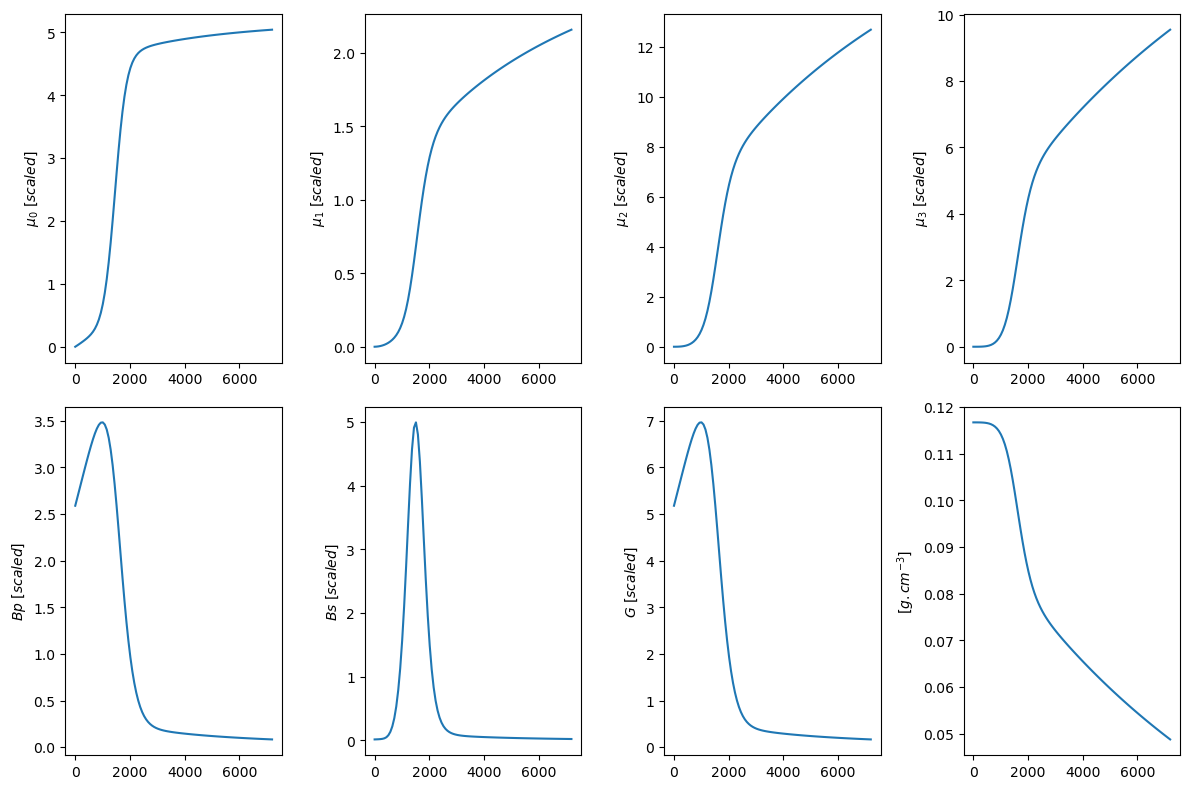

In [11]:
# Plot results
pyo_results = Results(m)
pyo_results.load_from_pyomo_model(m)
pyo_results.plot(undo_scaling=False)
# modify plot function, show data as the dots for the regression (concentration plot with saturation)

## Dynamic Optimization

## Parameter Estimation

### Generate Data

https://ndcbe.github.io/optimization/notebooks/5/Parmest-generate-data.html



In [12]:
# Load in pre-designed experiments

# Full_List   = pd.read_excel('Design of experiments.xlsx', names = ['Ci', 'Ti', 'tau', 'beta', 'eps', 'M_seed', 'Ls'], usecols = "O:U", skiprows = 32, nrows = 42)
Full_List   = pd.read_excel('Design of experiments.xlsx', names = ['Ci', 'Ti', 'tau', 'beta', 'eps', 'M_seed', 'Ls'], usecols = "O:U", skiprows = 32, nrows = 42)

# Scale experimental conditions appropriately
Full_List['Ci']     *= 1e-3
Full_List['eps']    *= 1e-3
Full_List['M_seed'] *= 1e-3
Full_List['Ls']     *= 1e3

# Prior_List      = list(range(0, 39, 11))
# Prior_List      = list(range(0, len(Full_List), 1))
# print(Prior_List)
Prior_List = [4, 18, 40]
Prior_Expts     = Full_List.iloc[Prior_List]
# Selection_Pool  = Full_List.drop(Prior_List)

# Restrict Selection_Pool while building out code - decide between few expts
# Selection_Pool  = Full_List.iloc[range(2, 39, 5)]
Selection_Pool  = Full_List.iloc[[6, 17, 28, 36, 39]]

print(len(Prior_Expts), 'prior experiments \n', len(Selection_Pool), 'in Selection Pool' )
Prior_Conditions = Prior_Expts.to_dict(orient='records')
# print(Prior_Conditions)

Selection_Pool = Selection_Pool.to_dict(orient='records')
# print(Selection_Pool)

3 prior experiments 
 5 in Selection Pool


In [13]:
print(Full_List)

          Ci      Ti   tau    beta     eps    M_seed    Ls
0   0.116685  315.40  7200  0.0000  0.0005  0.005821  0.02
1   0.116685  319.65  7200  0.0000  0.0005  0.004307  0.02
2   0.116685  323.90  7200  0.0000  0.0005  0.002400  0.02
3   0.034944  293.15  7200  0.0000  0.0005  0.001743  0.02
4   0.034944  297.40  7200  0.0000  0.0005  0.001290  0.02
5   0.034944  301.65  7200  0.0000  0.0005  0.000719  0.02
6   0.075026  307.25  7200  0.0000  0.0005  0.003743  0.02
7   0.075026  311.50  7200  0.0000  0.0005  0.002769  0.02
8   0.075026  315.75  7200  0.0000  0.0005  0.001543  0.02
9   0.116685  315.40  7200  0.0000  0.0005  0.000582  0.05
10  0.116685  315.40  7200  0.0000  0.0010  0.000582  0.05
11  0.116685  315.40  7200  0.0000  0.0015  0.000582  0.05
12  0.034944  293.15  7200  0.0000  0.0005  0.000174  0.05
13  0.034944  293.15  7200  0.0000  0.0010  0.000174  0.05
14  0.034944  293.15  7200  0.0000  0.0015  0.000174  0.05
15  0.075026  307.25  7200  0.0000  0.0005  0.000374  0.

In [14]:
experiments = []

for i in range(len(Prior_Conditions)):
    exp_i = typical_experiment()
    exp_i['Ci']     = Prior_Conditions[i]['Ci']
    exp_i['Ti']     = Prior_Conditions[i]['Ti']
    exp_i['beta']   = Prior_Conditions[i]['beta']
    exp_i['eps']    = Prior_Conditions[i]['eps']
    exp_i['M_seed'] = Prior_Conditions[i]['M_seed']
    exp_i['Ls']     = Prior_Conditions[i]['Ls']

    experiments.append(exp_i)


In [15]:
from pyomo.opt import SolverStatus, TerminationCondition
list_of_exp_data_frames = []
for i, exp in enumerate(experiments):
    print(Fore.RED + Back.GREEN + "\n***** Considering experiment",i+1," *****")
    print(exp)
    print(Style.RESET_ALL)

    # Create Pyomo model
    expt_selection = False # Use 'true' parameter values
    m = model_theta_switch(exp_conditions=exp)

    # Numerical intergrate to initialize

    # Solve using simulator
    int_ops = {'print_stats':True}
    sim = Simulator(m, package='casadi')
    tsim, profiles = sim.simulate(numpoints=100, integrator = 'idas', integrator_options=int_ops)

    # Discretize
    m.obj = pyo.Objective(expr=1)
    pyo.TransformationFactory('dae.finite_difference').apply_to(m, nfe=100, scheme='BACKWARD')
    sim.initialize_model()

    # Solve with Ipopt
    solver = pyo.SolverFactory('ipopt')
    solver.options['linear_solver'] = 'ma57'
    solver.solve(m,tee=True)

    

    # Extract results
    results = Results(m)
    results.load_from_pyomo_model(m)

    n = len(results.mu3)
    mu4_div_mu3 = np.zeros(n)
    for i in range(n):
        mu4_div_mu3[i] = results.mu4[i]/(results.mu3[i] + 1e-8)

    # Add noise to data
    def add_noise(vector):
        return np.array(vector) + np.random.normal(0, 0.05*np.std(vector), len(vector))
        # return np.array(vector) + np.random.normal(0, 0.5*np.std(vector), len(vector))


    C_noise     = add_noise(results.C)
    MT_noise    = add_noise(results.MT)
    mu4_div_mu3 = add_noise(mu4_div_mu3)

    Ci = np.ones(n)*exp['Ci']
    Ti = np.ones(n)*exp['Ti']

    df_temp = pd.DataFrame({"time":results.time[::5],"C":C_noise[::5],"MT":MT_noise[::5],"avg_volume":mu4_div_mu3[::5],"Ci":Ci[::5],"Ti":Ti[::5]})
    display(df_temp)

    # ============ FIND OUT HOW TO DETECT TERMINATION CONDITION: LOGIC STATEMENT TO ACCEPT/REJECT EXPERIMENTS BASED ON THIS ============
    # print(Fore.GREEN + Back.RED + results.solver.status + results.solver.termination_condition) 
    # print(m.name)
    # print(Style.RESET_ALL)

    list_of_exp_data_frames.append(df_temp)





***** Considering experiment 1  *****
{'Ci': 0.03494412532168334, 'Ti': 297.4, 'tau': 7200, 'beta': 0.0, 'eps': 0.0005, 'M_seed': 0.0012898033016374424, 'Ls': 0.02}

FORWARD INTEGRATION:
Number of steps taken by SUNDIALS: 380
Number of calls to the user's f function: 589
Number of calls made to the linear solver setup function: 38
Number of error test failures: 13
Method order used on the last internal step: 4
Method order to be used on the next internal step: 4
Actual value of initial step size: 6.17926e-05
Step size taken on the last internal step: 166.867
Step size to be attempted on the next internal step: 333.734
Current internal time reached: 7200
Number of nonlinear iterations performed: 587
Number of nonlinear convergence failures: 0

Ipopt 3.11.1: linear_solver=ma57


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Ecli

,time,C,MT,avg_volume,Ci,Ti
0,0.0,0.034863,0.001182,0.200782,0.034944,297.4
1,360.0,0.024147,0.011881,0.463425,0.034944,297.4
2,720.0,0.022231,0.013866,0.483329,0.034944,297.4
3,1080.0,0.022036,0.014242,0.484459,0.034944,297.4
4,1440.0,0.022116,0.014213,0.487685,0.034944,297.4
5,1800.0,0.021865,0.014097,0.485340,0.034944,297.4
6,2160.0,0.022030,0.014186,0.485864,0.034944,297.4
7,2520.0,0.022031,0.014140,0.480593,0.034944,297.4
8,2880.0,0.022184,0.014254,0.487046,0.034944,297.4
9,3240.0,0.022081,0.014169,0.486154,0.034944,297.4



***** Considering experiment 2  *****
{'Ci': 0.11668498484808734, 'Ti': 315.4, 'tau': 7200, 'beta': 0.0, 'eps': 0.0005, 'M_seed': 0.0005821255453377081, 'Ls': 0.1}

FORWARD INTEGRATION:
Number of steps taken by SUNDIALS: 478
Number of calls to the user's f function: 726
Number of calls made to the linear solver setup function: 49
Number of error test failures: 14
Method order used on the last internal step: 3
Method order to be used on the next internal step: 3
Actual value of initial step size: 8.06471e-06
Step size taken on the last internal step: 12.6389
Step size to be attempted on the next internal step: 25.2778
Current internal time reached: 7200
Number of nonlinear iterations performed: 724
Number of nonlinear convergence failures: 0

Ipopt 3.11.1: linear_solver=ma57


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclip

,time,C,MT,avg_volume,Ci,Ti
0,0.0,0.116470,0.000708,1.001060,0.116685,315.4
1,360.0,0.080443,0.036699,0.750021,0.116685,315.4
2,720.0,0.060483,0.057515,0.758075,0.116685,315.4
3,1080.0,0.058959,0.058761,0.756679,0.116685,315.4
4,1440.0,0.058436,0.059371,0.756543,0.116685,315.4
5,1800.0,0.058479,0.059233,0.757716,0.116685,315.4
6,2160.0,0.058092,0.058710,0.760765,0.116685,315.4
7,2520.0,0.058324,0.057737,0.757120,0.116685,315.4
8,2880.0,0.058681,0.059342,0.757497,0.116685,315.4
9,3240.0,0.058158,0.058830,0.759958,0.116685,315.4



***** Considering experiment 3  *****
{'Ci': 0.07502559833781035, 'Ti': 325.0, 'tau': 7200, 'beta': 0.003, 'eps': 0.0005, 'M_seed': 0.0, 'Ls': 0.02}

FORWARD INTEGRATION:
Number of steps taken by SUNDIALS: 947
Number of calls to the user's f function: 1648
Number of calls made to the linear solver setup function: 120
Number of error test failures: 40
Method order used on the last internal step: 4
Method order to be used on the next internal step: 4
Actual value of initial step size: 0.0727273
Step size taken on the last internal step: 28.9211
Step size to be attempted on the next internal step: 57.8423
Current internal time reached: 7200
Number of nonlinear iterations performed: 1646
Number of nonlinear convergence failures: 0

Ipopt 3.11.1: linear_solver=ma57


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public Lice

,time,C,MT,avg_volume,Ci,Ti
0,0.0,0.074861,-0.000741,0.001039,0.075026,325.0
1,360.0,0.075028,-0.001615,0.033439,0.075026,325.0
2,720.0,0.074999,0.000992,-0.042724,0.075026,325.0
3,1080.0,0.074839,0.000547,0.006074,0.075026,325.0
4,1440.0,0.075237,0.000257,-0.020112,0.075026,325.0
5,1800.0,0.075662,0.000108,0.040387,0.075026,325.0
6,2160.0,0.075044,0.000294,0.080852,0.075026,325.0
7,2520.0,0.075998,-0.000587,0.163501,0.075026,325.0
8,2880.0,0.075859,0.001344,0.284612,0.075026,325.0
9,3240.0,0.074088,0.002355,0.463310,0.075026,325.0


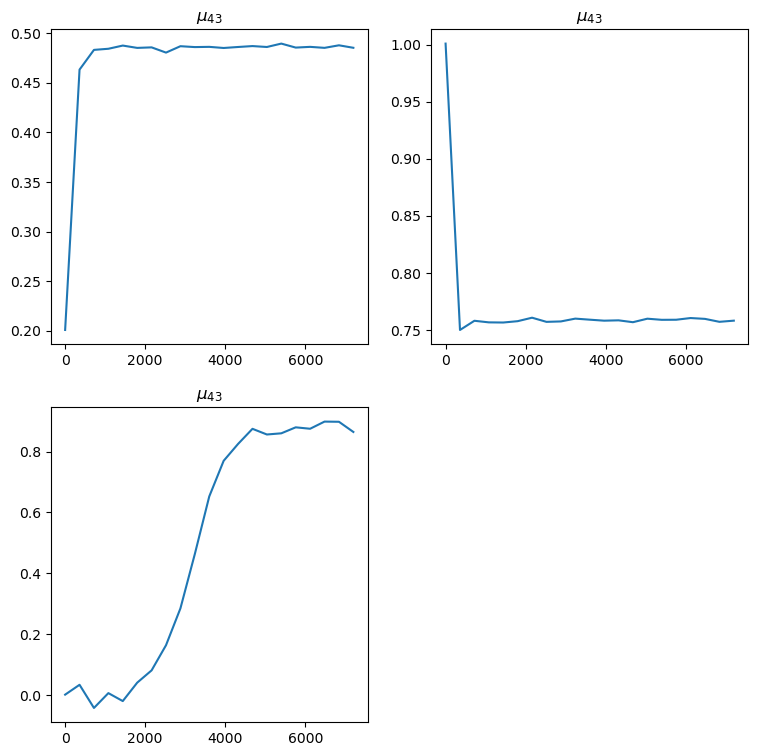

In [16]:
# (Optional) Inspect data from prior experiments - C profiles

fig = plt.figure(figsize=(9, 9))
fig_size = int(np.ceil(np.sqrt(len(Prior_Expts))))

for i in range(len(Prior_Expts)):
    x = list_of_exp_data_frames[i]["time"]
    y = list_of_exp_data_frames[i]["avg_volume"]
    plt.subplot(fig_size, fig_size, i+1)
    plt.plot(x,y)
    plt.title("$\mu_{43}$")


# for i in range(len(Prior_Expts)):
#     x = list_of_exp_data_frames[i]["time"]
#     y = list_of_exp_data_frames[i]["C"]
#     plt.subplot(fig_size, fig_size, i+1)
#     plt.plot(x,y)
#     plt.title("C profile")


### Estimate with Parmest

https://ndcbe.github.io/optimization/notebooks/5/Parmest-tutorial.html

In [17]:
# ========== data dict test ==============

prior_data_prep = []

for i in range(len(Prior_Expts)):
    data_dict_test          = {}
    data_dict_test['Ci']    = list_of_exp_data_frames[i]['Ci'].iloc[0]
    data_dict_test['Ti']    = list_of_exp_data_frames[i]['Ti'].iloc[0]
    
    meas_data = list_of_exp_data_frames[i].drop(labels=['Ci','Ti'],axis=1)

    prior_data_prep.append(meas_data)

# print(type(dataaa))
print(type(prior_data_prep))
# print(np.shape(list_of_exp_data_frames))


<class 'list'>


In [18]:
# Create csv file names for prior experiments
file_list = []

for i in range(len(list_of_exp_data_frames)):
    prior_data_prep[i].to_csv('prior' + str(i), index=False)
    file_list.append('prior' + str(i))

print(file_list)

['prior0', 'prior1', 'prior2']


In [19]:
def create_prior_data_dict(files):
    '''
    Create a list of dictionaries from multiple datasets
    Arguments:
        files: pandas dataframe of file names
    Return:
        data_dict_list: list of dictionaries
    '''
    data_dict_list = []
    for i in range(len(Prior_Expts)):
        # create a dictionary of 'experimental' data for each set of exp conditions
        data_dict   = {}
        data_dict   = Prior_Conditions[i]           # Conditions for experiment
        data_dict['data'] = pd.read_csv(files[i])   # Corresponding exp measurements
        # add dictionary to list to be return
        data_dict_list.append(data_dict)
    return data_dict_list


In [20]:
data_dict_list = []

for i in range(len(Prior_Expts)):
    # create a dictionary of 'experimental' data for each set of exp conditions
    data_dict   = {}
    data_dict   = Prior_Conditions[i]               # Conditions for experiment
    data_dict['data'] = pd.read_csv(file_list[i])   # Corresponding exp measurements
    # add dictionary to list to be return
    data_dict_list.append(data_dict)

print(np.shape(data_dict_list))

(3,)


In [21]:
def Cryst_model_parmest(data):
    '''
    Special create_model function for parmest
    '''

    # Extract measurement data
    exp_data = data['data']

    # temp store for experimental measurements
    c_meas_temp       = exp_data['C']
    mt_meas_temp      = exp_data['MT']
    avg_vol_meas_temp = exp_data['avg_volume']
    t_meas_temp       = exp_data['time']

    # create dictionaries for multiple experimental datasets
    cmeas        = {}
    mtmeas       = {}
    avg_vol_meas = {}
    for i,j in enumerate(t_meas_temp):
        cmeas[float(j)]         = c_meas_temp[i]
        mtmeas[float(j)]        = mt_meas_temp[i]
        avg_vol_meas[float(j)]  = avg_vol_meas_temp[i]

    # New pyomo model for parmest 
    m = pyo.ConcreteModel()

    # Give experimental conditions for each dataset to the model
    m.Ci        = data['Ci']
    m.Ti        = data['Ti']
    m.tau       = data['tau']
    m.beta      = data['beta']
    m.eps       = data['eps']
    m.M_seed    = data['M_seed']
    m.Ls        = data['Ls']

    print(data['Ti']) # flag whether we're using multiple experiments or just one

    # Define timeset from extracted data
    m.t = ContinuousSet(bounds = (0.0, t_meas_temp.iloc[-1]), initialize=t_meas_temp.tolist())

    # define 'experimental' data as Pyomo parameters indexed by timestep set and
    # initialized by dictionary of experimental data
    m.Cmeas         = pyo.Param(m.t, initialize=cmeas)
    m.MTmeas        = pyo.Param(m.t, initialize=mtmeas)
    m.Avg_vol_meas  = pyo.Param(m.t, initialize=avg_vol_meas)


    # Define physical properties & constants
    rho     = 1360 * 1e-6       # crystal density [g.mm-3]
    kv      = 0.523             # volume shape factor
    C1      = 2.209e-6 * 1e-3   # solubility parameter 1 (for g.cm-3)
    C2      = 5.419e-2          # solubility parameter 2

    # Scaling parameters 
    m.mu0_scale      = 1e5
    m.mu1_scale      = 1e4
    m.mu2_scale      = 1e2
    m.mu3_scale      = 1e1
    m.mu4_scale      = 1e0

    m.Bp_scale       = 1e1      # Primary nucl. scaling
    m.Bs_scale       = 1e2      # Seconday nucl. scaling
    m.G_scale        = 1e-5

    ## New Bounds ##
    # m.theta_lb = {'kb1': 1e1, 'b1': 1, 'kb2': 1e6, 'b2': 1, 'kg': 2e-6, 'g': 1}
    m.theta_lb = {'kg': 1e-6, 'g': 1}     # PARAMETER SEARCH RANGE
    # m.theta_ub = {'kb1': 1e4, 'b1': 4, 'kb2': 1e12, 'b2': 5, 'kg': 2e-2, 'g': 3}
    m.theta_ub = {'kg': 1e-2, 'g': 3}    # PARAMETER SEARCH RANGE

    # m.kb1 = pyo.Var(initialize = np.log(m.theta['kb1']), bounds=(np.log(m.theta_lb['kb1']), np.log(m.theta_ub['kb1'])))
    # m.kb2 = pyo.Var(initialize = np.log(m.theta['kb2']), bounds=(np.log(m.theta_lb['kb2']), np.log(m.theta_ub['kb2'])))
    # m.kg  = pyo.Var(initialize = np.log(m.theta['kg']), bounds=(np.log(m.theta_lb['kg']), np.log(m.theta_ub['kg'])))
    
    # m.b1  = pyo.Var(initialize = m.theta['b1'], bounds=(m.theta_lb['b1'], m.theta_ub['b1']))
    # m.b2  = pyo.Var(initialize = m.theta['b2'], bounds=(m.theta_lb['b2'], m.theta_ub['b2']))
    # m.g   = pyo.Var(initialize = m.theta['g'], bounds=(m.theta_lb['g'], m.theta_ub['g']))


    # # Kinetic parameters to be fitted defined as Pyomo variables
    # if theta_est is not None:   # if we have estimates already; use them
    #     m.kb1   = pyo.Var(initialize=theta_est['kb1'],  bounds=(1e1,1e3)) 
    #     m.b1    = pyo.Var(initialize=theta_est['b1'],   bounds=(1,2)) 
    #     m.kb2   = pyo.Var(initialize=theta_est['kb2'],  bounds=(1e8,1e10)) 
    #     m.b2    = pyo.Var(initialize=theta_est['b2'],   bounds=(1,3))
    #     m.kg    = pyo.Var(initialize=theta_est['kg'],   bounds=(2e-5,2e-3)) 
    #     m.g     = pyo.Var(initialize=theta_est['g'],    bounds=(1,2))
    # else:                       # otherwise use these initial guesses
    #     m.kb1   = pyo.Var(initialize = 5e2,             bounds=(1e1,1e3)) 
    #     m.b1    = pyo.Var(initialize = 1,               bounds=(1,2)) 
    #     m.kb2   = pyo.Var(initialize = 2e8,             bounds=(1e8,1e10)) 
    #     m.b2    = pyo.Var(initialize = 2,               bounds=(1,3))
    #     m.kg    = pyo.Var(initialize = 3e-4,            bounds=(2e-5,2e-3)) 
    #     m.g     = pyo.Var(initialize = 1,               bounds=(1,2))


    kb1_err     = 0.65
    b1_err      = 1.15
    kb2_err     = 1.35
    b2_err      = 0.95

    # Log transformation
    if theta_est is not None:   # if we have estimates already; use them
        # m.kb1   = pyo.Var(initialize=np.log(theta_est['kb1']),  bounds=(np.log(m.theta_lb['kb1']),np.log(m.theta_ub['kb1'])))
        # m.b1    = pyo.Var(initialize=theta_est['b1'],           bounds=(m.theta_lb['b1'],m.theta_ub['b1'])) 
        # m.kb2   = pyo.Var(initialize=np.log(theta_est['kb2']),  bounds=(np.log(m.theta_lb['kb2']),np.log(m.theta_ub['kb2']))) 
        # m.b2    = pyo.Var(initialize=theta_est['b2'],           bounds=(m.theta_lb['b2'],m.theta_ub['b2']))


        m.kb1   = np.log(1e2 * kb1_err)
        m.b1    = 1 * b1_err
        m.kb2   = np.log(1e9 * kb2_err)
        m.b2    = 2 * b2_err

        m.kg    = pyo.Var(initialize=np.log(theta_est['kg']),   bounds=(np.log(m.theta_lb['kg']),np.log(m.theta_ub['kg']))) 
        m.g     = pyo.Var(initialize=theta_est['g'],            bounds=(m.theta_lb['g'],m.theta_ub['g']))
    else:                       # otherwise use these initial guesses
        # m.kb1   = pyo.Var(initialize = np.log(3e2),             bounds=(np.log(m.theta_lb['kb1']),np.log(m.theta_ub['kb1'])))
        # m.b1    = pyo.Var(initialize = 1,                       bounds=(m.theta_lb['b1'],m.theta_ub['b1'])) 
        # m.kb2   = pyo.Var(initialize = np.log(8e8),             bounds=(np.log(m.theta_lb['kb2']),np.log(m.theta_ub['kb2']))) 
        # m.b2    = pyo.Var(initialize = 2,                       bounds=(m.theta_lb['b2'],m.theta_ub['b2']))

        m.kb1   = np.log(1e2 * kb1_err)
        m.b1    = 1 * b1_err
        m.kb2   = np.log(1e9 * kb2_err)
        m.b2    = 2 * b2_err
    
        m.kg    = pyo.Var(initialize = np.log(3e-5),            bounds=(np.log(m.theta_lb['kg']),np.log(m.theta_ub['kg']))) 
        m.g     = pyo.Var(initialize = 2,                       bounds=(m.theta_lb['g'],m.theta_ub['g']))



    # Initialize experimental conditions [moments, measureables, growth/nuceleation]
    m.mu0 = pyo.Var(m.t, initialize = m.M_seed / (rho*kv*m.Ls**3)/m.mu0_scale, within = pyo.NonNegativeReals)
    m.mu1 = pyo.Var(m.t, initialize = m.M_seed / (rho*kv*m.Ls**4)/m.mu0_scale, within = pyo.NonNegativeReals)
    m.mu2 = pyo.Var(m.t, initialize = m.M_seed / (rho*kv*m.Ls**5)/m.mu0_scale, within = pyo.NonNegativeReals)
    m.mu3 = pyo.Var(m.t, initialize = m.M_seed / (rho*kv*m.Ls**6)/m.mu0_scale, within = pyo.NonNegativeReals)
    m.mu4 = pyo.Var(m.t, initialize = m.M_seed / (rho*kv*m.Ls**7)/m.mu0_scale, within = pyo.NonNegativeReals)

    m.C       = pyo.Var(m.t, initialize = m.Ci,     within = pyo.NonNegativeReals)
    m.T       = pyo.Var(m.t, initialize = m.Ti,     within = pyo.NonNegativeReals)
    m.MT      = pyo.Var(m.t, initialize = m.M_seed, within = pyo.NonNegativeReals)
    m.avg_vol = pyo.Var(m.t, initialize = m.Ls,     within = pyo.NonNegativeReals)

    m.G     = pyo.Var(m.t, initialize = 0, within = pyo.NonNegativeReals)
    m.Bp    = pyo.Var(m.t, initialize = 0, within = pyo.NonNegativeReals)
    m.Bs    = pyo.Var(m.t, initialize = 0, within = pyo.NonNegativeReals)

    # Declare Derivative pyo.Variable
    m.dmu0 = DerivativeVar(m.mu0)
    m.dmu1 = DerivativeVar(m.mu1)
    m.dmu2 = DerivativeVar(m.mu2)
    m.dmu3 = DerivativeVar(m.mu3)
    m.dmu4 = DerivativeVar(m.mu4)
    m.dC   = DerivativeVar(m.C)
    m.dMT  = DerivativeVar(m.MT)
    m.dT   = DerivativeVar(m.T)

    '''
    m.kb1 = pyo.Param(initialize = m.theta['kb1'], mutable = True)
    m.b1  = pyo.Param(initialize = m.theta['b1'], mutable = True)
    m.kb2 = pyo.Param(initialize = m.theta['kb2'], mutable = True)
    m.b2  = pyo.Param(initialize = m.theta['b2'], mutable = True)
    m.kg  = pyo.Param(initialize = m.theta['kg'], mutable = True)
    m.g   = pyo.Param(initialize = m.theta['g'], mutable = True)
    '''

    # Fix the parameters
    # m.kb1.fix()
    # m.b1.fix()
    # m.kb2.fix()
    # m.b2.fix()
    m.kg.fix()
    m.g.fix()

    alt_rel_sat = True

    def smooth_max(z):
        return 0.5*(pyo.sqrt(z**2+1e-8)+z)

    # Solubility expression
    def solubility(T):
        return C1*pyo.exp(C2*T)

    def inv_solubility(T):
        return pyo.exp(-C2*T)/C1
    

    # Primary and Secondary nucleation separated (for scaling purposes)
    @m.Constraint(m.t)
    def prim_nucl(m, t):
        # Relative supersaturation computation
        if alt_rel_sat:
            rel_sat = m.C[t]*inv_solubility(m.T[t])-1
        else:
            rel_sat = (m.C[t] - solubility(m.T[t]))/solubility(m.T[t])

        # return m.Bp[t] == (m.kb1*smooth_max(rel_sat)**m.b1) / m.Bp_scale
        return m.Bp[t] == (pyo.exp(m.kb1)*smooth_max(rel_sat)**m.b1) / m.Bp_scale

    @m.Constraint(m.t)
    def sec_nucl(m, t):
        # Relative supersaturation computation
        if alt_rel_sat:
            rel_sat = m.C[t]*inv_solubility(m.T[t])-1
        else:
            rel_sat = (m.C[t] - solubility(m.T[t]))/solubility(m.T[t])

        # return m.Bs[t] == (m.kb2*smooth_max(rel_sat)**m.b2)*m.eps*(m.MT[t]) / m.Bs_scale
        return m.Bs[t] == (pyo.exp(m.kb2)*smooth_max(rel_sat)**m.b2)*m.eps*(smooth_max(m.MT[t])) / m.Bs_scale


    @m.Constraint(m.t)
    def growth(m, t):
        # Relative supersaturation computation
        if alt_rel_sat:
            rel_sat = m.C[t]*inv_solubility(m.T[t])-1
        else:
            rel_sat = (m.C[t] - solubility(m.T[t]))/solubility(m.T[t])
        # Growth rate expression
        # return m.G[t] == (m.kg*smooth_max(rel_sat)**m.g) / m.G_scale
        return m.G[t] == (pyo.exp(m.kg)*smooth_max(rel_sat)**m.g) / m.G_scale


    # Constraints for moments and concentration (fixed) for units of mm (L) and mL, or cm^3 (V)
    # @m.Constraint(m.t)
    # def ode1(m, t):
    #     return m.dmu0[t] == m.B[t] * m.B_scale / m.mu0_scale #* m.tau  # Units of # / cm^3 / s

    @m.Constraint(m.t)
    def ode1(m, t):
        return m.dmu0[t] == (m.Bp[t] * m.Bp_scale + m.Bs[t] * m.Bs_scale) / m.mu0_scale #* m.tau  # Units of # / cm^3 / s

    @m.Constraint(m.t)
    def ode2(m, t):
        return m.dmu1[t] == 1 * m.G[t] * m.G_scale * m.mu0[t] * m.mu0_scale / m.mu1_scale #* m.tau  # Units of mm * # / cm^3 / s

    @m.Constraint(m.t)
    def ode3(m, t):
        return m.dmu2[t] == 2 * m.G[t] * m.G_scale * m.mu1[t] * m.mu1_scale / m.mu2_scale #* m.tau  # Units of mm^2 * # / cm^3 / s

    @m.Constraint(m.t)
    def ode4(m, t):
        return m.dmu3[t] == 3 * m.G[t] * m.G_scale * m.mu2[t] * m.mu2_scale / m.mu3_scale #* m.tau  # Units of mm^3 * # / cm^3 / s

    @m.Constraint(m.t)
    def ode5(m, t):
        return m.dmu4[t] == 4 * m.G[t] * m.G_scale * m.mu3[t] * m.mu3_scale / m.mu4_scale #* m.tau  # Units of mm^4 * # / cm^3 / s

    @m.Constraint(m.t)
    def ode6(m, t):
        return m.dC[t] == -3 * kv * rho * m.G[t] * m.G_scale * smooth_max(m.mu2[t]) * m.mu2_scale #* m.tau  # Units of g / cm^3 / s

    # @m.Constraint(m.t)
    # def MT_balance(m, t):
    #     return m.MT[t] == rho * kv * m.mu3[t] * m.mu3_scale # Units of grams.mm-3

    @m.Constraint(m.t)
    def ode7(m, t):
        return m.dMT[t] == 3 * kv * rho * m.G[t] * m.G_scale * smooth_max(m.mu2[t]) * m.mu2_scale # Units of grams.mm-3

    @m.Constraint(m.t)
    def ode8(m, t):
        return m.dT[t] == -m.beta # * m.tau
        # beta[0] is 0 (temperature decay), if we set it to something else we will get something else
        # change beta 0 to something physical
        # (0,(0.5/60))

    @m.Constraint(m.t)
    def average_volume(m,t):
        return (m.mu4[t] + 1e-8) * m.mu4_scale == m.avg_vol[t] * (m.mu3[t] + 1e-8) * m.mu3_scale  # / 1000    Multiplying by 1000 to get in micrometers????
        # return (m.mu1[t] + 1e-8) * m.mu1_scale == m.avg_vol[t] * (m.mu0[t] + 1e-8) * m.mu0_scale


    # Initial conditions (fixed), in units desired (mm and cm^3)
    m.mu0[0.0].fix(m.M_seed/(rho*kv*m.Ls**3)/m.mu0_scale)
    m.mu1[0.0].fix(m.mu0[0.0]*m.mu0_scale*m.Ls/(m.mu1_scale))
    m.mu2[0.0].fix(m.mu0[0.0]*m.mu0_scale*(m.Ls)**2/m.mu2_scale)
    m.mu3[0.0].fix(m.mu0[0.0]*m.mu0_scale*(m.Ls)**3/m.mu3_scale)
    m.mu4[0.0].fix(m.mu0[0.0]*m.mu0_scale*(m.Ls)**4/m.mu4_scale)

    # m.C[0.0].fix(m.Ci[0])
    # m.MT[0.0].fix(m.M_seed[0])
    # m.T[0].fix(m.Ti[0])

    # m.beta[0].fix(m.beta[0])

    # m.C[0.0].fix(m.Ci)
    # m.MT[0.0].fix(m.M_seed)
    # m.T[0].fix(m.Ti)

    # m.beta[0].fix(m.beta[0.0])


    ## Numerical intergrate to initialize
    sim = Simulator(m, package='casadi')
    tsim, profiles = sim.simulate(integrator = 'idas')

    ## Discretize
    pyo.TransformationFactory('dae.finite_difference').apply_to(m, nfe=100,scheme='BACKWARD')
    sim.initialize_model()
    
    # # Prepare data
    # for i,t in enumerate(data['data'].time):
    #     C_measure[float(t)] = data['data'].C[i]
    #     MT_measure[float(t)] = data['data'].MT[i]
    #     avg_vol_measure[float(t)] = data['data'].avg_volume[i]

    # # print(C_measure)
    # # print(m.C)

    # # Least squares objective
    def ComputeFirstStageCost_rule(m):
        return 0
    m.FirstStageCost = pyo.Expression(rule=ComputeFirstStageCost_rule)

    def ComputeSecondStageCost_rule(m):
      # measurements
        # return sum((m.C[t] - c_meas_temp [ind]) ** 2 + (m.MT[t] - mt_meas_temp [ind]) ** 2
        #                + (m.avg_vol[t] - avg_vol_meas_temp[ind]) ** 2 for ind, t in enumerate(t_meas_temp))
        return sum((m.C[t] - c_meas_temp [ind]) ** 2
                       + (100 * m.avg_vol[t] - 100 * avg_vol_meas_temp[ind]) ** 2 for ind, t in enumerate(t_meas_temp))
    m.SecondStageCost = pyo.Expression(rule=ComputeSecondStageCost_rule)

    # return the sum of the first-stage and second-stage costs as the objective function
    def total_cost_rule(m):
        return m.FirstStageCost + m.SecondStageCost

    m.total_cost_objective = pyo.Objective(rule=total_cost_rule, sense=pyo.minimize)

    return m

In [22]:
import pyomo.contrib.parmest.parmest as parmest

# defining the names of the parameters in a list
theta_names = list(m.theta.keys())
theta_names = ['kg', 'g']


# No. datapoints within set
len_data    = len(data_dict_list) * 101 #No. expts * No. timepoints

expt_selection = True   # Set model_theta_switch blind to true parameter values

# create an object using parmest.Estimator() that stores the Pyomo model realizations for the datasets provided.
# This object which will be used to determined the parameter values that best fit all the datasets
pest = parmest.Estimator(Cryst_model_parmest,data_dict_list,theta_names,tee=True,solver_options={'bound_push': 1E-7,
                                                                                                 'halt_on_ampl_error': 'yes',#})
                                                                                                 'linear_solver': 'ma27',
                                                                                                 'max_iter':3000})


# call the method theta_est() for the Estimator() object defined above to solve
# the parameter estimation problem.
# theta_est() returns:
    # the overall objective function value
    # estimated parameter values (dictionary with keys = parameters names as defined in the Pyomo model)

theta_est = None    # No estimates yet: define as None for logic statement
obj, theta = pest.theta_est()

print('theta:\n',theta)
print(np.shape(list_of_exp_data_frames))

297.4
315.4
325.0
Ipopt 3.11.1: bound_push=1e-07
halt_on_ampl_error=yes
linear_solver=ma27
max_iter=3000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

NOTE: You are using Ipopt by default with the MUMPS linear solver.
      Other linear solvers might be more efficient (see Ipopt documentation).


This is Ipopt version 3.11.1, running with linear solver ma27.

Number of nonzeros in equality constraint Jacobian...:    18376
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     4902

Total number of variables............................:     6051
                     variables with on

In [23]:
# Extracting un-scaled values of theta from parmest
theta_est = {'kg': np.exp(theta[0]),'g': theta[1]}
print(theta)
print(theta_est)
theta_est_list = []
theta_est_list.append(theta_est)

kg   -7.106646
g     1.517173
dtype: float64
{'kg': 0.0008196391371319103, 'g': 1.5171732869606243}


In [24]:
# if theta_est is not None:
#     print('working')
# else:
#     print('not working')


In [25]:
# Define DoE object parameters ---> tidy up later 

#=====================================================================
# Gather time points you want. Probably can specify from the model(??)
time_control = []
old_div = -1
for i in range(51):
    if int(i * 144 / 900) != old_div:
      old_div = int(i * 144 / 900)
      time_control.append(i * 144)
print(time_control)
# Defining the control time set (hours)
#time_control = [0, 0.25, 0.50, 0.75, 1]
# m.theta_lb = {'kb1': 1e1, 'b1': 1, 'kb2': 1e6, 'b2': 1, 'kg': 2e-6, 'g': 1}
# param_lb = {'kb1': 1e1, 'b1': 1, 'kb2': 1e6, 'b2': 1, 'kg': 2e-6, 'g': 1}
# Defining parameter nominal value
# parameter_dict = {'kb1':10,'b1':0.1,'kb2':100,'b2': 0.2, 'kg': 0.00002, 'g': 0.54641}
parameter_dict = dict(theta)
# move to adhere with bounds
# parameter_dict['kb1'] *= 1.03
# parameter_dict['b1'] *= 0.97
# parameter_dict['kb2'] *= 1.03
# parameter_dict['b2'] *= 1.03

# for key in parameter_dict.keys()
#   parameter_dict[key]
# parameter_dict = {k:v*1.01 for (k, v) in parameter_dict
#============================================================================
# Defining measurements (physically measuring -- need to change)
measurement_class = MeasurementVariables()
variable_name='C'
#sum((m.C[t] - C_measure[t]) ** 2 + (m.MT[t] - MT_measure[t]) ** 2
 #                      + (m.avg_vol[t] - avg_vol_measure[t]) ** 2 for t in t_measure)
indices = {0:time_control}
# Adding measurements variables
measurement_class.add_variables('C',indices=indices, time_index_position=0,variance=1e-1*0.05)
measurement_class.add_variables('MT',indices=indices, time_index_position=0,variance=1e-1*0.05)
measurement_class.add_variables('avg_vol',indices=indices, time_index_position=0,variance=1e-3)
# print('Measurement names:', measurement_class.variable_names
# Design variables (manipulate to make experiment more informative -- Ci is fine for now)
design_vars = DesignVariables()

var_C = 'Ci'
# var_C = 'C'
indices_C = [0, ]
exp1_C = [95e-3,] 
var_T = 'Ti'
indices_T = {0:[0]}
exp1_T = [325, ]
design_vars.add_variables(var_T, indices = indices_T, time_index_position=0, values=exp1_T,
                          lower_bounds=293.15, upper_bounds=333.15)  
print("Design variable names:", design_vars.variable_names)
# Sensitivity selection
# sensitivity_option = 'sequential_finite'
# sensitivity_option = 'direct_kaug'
# Define experiments
design_names = design_vars.variable_names
control_time = [0]
exp1 = (control_time, 325)
# exp1 = 
# exp1_design_dict = dict(zip(design_names, exp1)
# print(exp1_design_dict)
print(exp1)
# design_vars.update_values(exp1_design_dict
#=========================================================================


[0, 1008, 1872, 2736, 3600, 4608, 5472, 6336, 7200]
Design variable names: ['Ti[0]']
([0], 325)


In [26]:
def disc_for_measure(m, nfe=50, block=True):
    """
    Pyomo.DAE discretization

    Arguments
    ---------
    m: Pyomo model
    nfe: number of finite elements b
    block: if True, the input model has blocks
    """
    # Discretization using collocation
    discretizer = pyo.TransformationFactory("dae.finite_difference")
    # nfe = 50
    # discretizer = pyo.TransformationFactory("dae.collocation")
    if block:
        for s in range(len(m.block)):
            discretizer.apply_to(m.block[s], nfe=nfe, wrt=m.block[s].t, scheme='BACKWARD')
            sim = Simulator(m.block[s], package='casadi')
            # discretizer.apply_to(m.block[s], nfe=nfe, ncp=3, wrt=m.block[s].t, scheme='LAGRANGE-RADAU')
            tsim, profiles = sim.simulate(numpoints=150, integrator = 'idas', integrator_options=int_ops)
            sim.initialize_model()
    else:
        # TODO: Add simulation to this case
        discretizer.apply_to(m, nfe=nfe, wrt=m.t, scheme='BACKWARD')
        # discretizer.apply_to(m.block[s], nfe=nfe, ncp=6, wrt=m.block[s].t, scheme='LAGRANGE-RADAU')
    return m

In [27]:
# sensitivity_option = 'direct_kaug'
sensitivity_option = 'sequential_finite'
solver.options = {'bound_push':1E-8, 'max_iter':3000,'linear_solver': 'ma57'}

expt_selection = True           # Use estimated parameter set

doe_object = DesignOfExperiments(parameter_dict, # dictionary of parameters
design_vars,       # design variables
measurement_class, # measurements
model_theta_switch,# model
solver = solver,   # solver option
discretize_model = disc_for_measure)

# Compute FIM
result          = doe_object.compute_FIM(mode = sensitivity_option, # sensitivity option
FIM_store_name  = 'dynamic.csv',    # FIM results
read_output     = None,             # output
scale_nominal_param_value = True,   # scaling
formula         = "central")        # central finite difference

result.result_analysis()

FORWARD INTEGRATION:
Number of steps taken by SUNDIALS: 826
Number of calls to the user's f function: 1419
Number of calls made to the linear solver setup function: 151
Number of error test failures: 65
Method order used on the last internal step: 4
Method order to be used on the next internal step: 4
Actual value of initial step size: 6.28249e-05
Step size taken on the last internal step: 54.8499
Step size to be attempted on the next internal step: 54.8499
Current internal time reached: 7200
Number of nonlinear iterations performed: 1417
Number of nonlinear convergence failures: 0

FORWARD INTEGRATION:
Number of steps taken by SUNDIALS: 705
Number of calls to the user's f function: 1290
Number of calls made to the linear solver setup function: 75
Number of error test failures: 30
Method order used on the last internal step: 3
Method order to be used on the next internal step: 3
Actual value of initial step size: 6.28249e-05
Step size taken on the last internal step: 6.44229
Step size 

In [28]:
cov_est   = [] # Create list: covariance matrix for each parameter estimation
trace_est = [] # Create list: det(cov) for each cov. matrix
FIM_store = []

cov_est.append(np.linalg.inv(result.FIM))               # Get covariance matrix of initial parameter set estimation
trace_est.append(np.trace(np.linalg.inv(result.FIM)))   # Get trace(cov) which indicates volume of combined confidence ellipsoid
FIM_store.append(result.FIM)
print(trace_est)

[8.845491766307598]


In [29]:
print((cov_est[0]))
print(theta_names)

[[ 0.79834133 -2.53126104]
 [-2.53126104  8.04715044]]
['kg', 'g']


In [30]:
# Eigenvalue decomposition of covariance matrix for confidence ellipses
def eigsorted(cov):
    vals, vecs = np.linalg.eigh(cov)
    order = vals.argsort()[::-1]
    return vals[order], vecs[:,order]

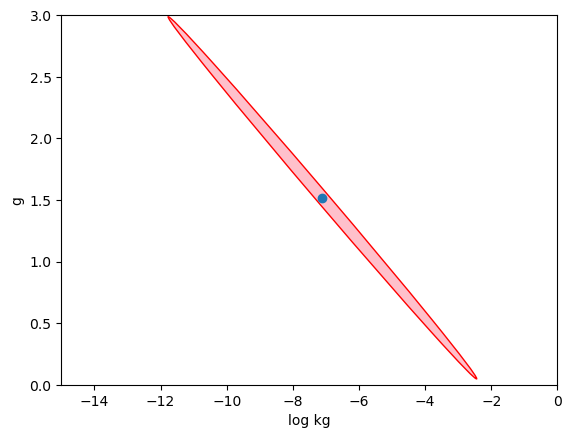

In [34]:
cov1   = [cov_est[0][0][0], cov_est[0][0][1]]
cov2   = [cov_est[0][1][0], cov_est[0][1][1]]
covtot = [cov1, cov2]
vals, vecs = eigsorted(covtot)

nstd = 1.645            # No. st. dev.s == confidence interval
ax   = plt.subplot(111)


rotate = np.degrees(np.arctan2(*vecs[:,0][::-1]))   # direction of eigenvector
w, h   = 2 * nstd * np.sqrt(vals)                   # length of eigenvalues
ell    = Ellipse(xy=(theta['kg'], theta['g']),
              width=h, height=w,
              angle=-rotate, color='Red')
ell.set_facecolor('pink')
ax.add_artist(ell)
ax.set_xlim(left=-15, right=0)
ax.set_ylim(top=3, bottom=-0)
plt.xlabel("log kg")
plt.ylabel("g")
# ax.set_xscale('log')
# ax.set_yscale('log')
# ax.set_ylim(left=theta_est['b1']-h*2, right=theta_est['b1']+h*2)
plt.scatter(theta['kg'], theta['g'])
plt.show()


In [35]:
Heatmap_expts = pd.read_excel('Design of experiments.xlsx', names = ['Ci', 'Ti', 'tau', 'beta', 'eps', 'M_seed', 'Ls'], usecols = "O:U", skiprows = 87, nrows = 25)

# Scale experimental conditions appropriately
Heatmap_expts['Ci']     *= 1e-3
Heatmap_expts['eps']    *= 1e-3
Heatmap_expts['M_seed'] *= 1e-3
Heatmap_expts['Ls']     *= 1e3

print(Heatmap_expts)

          Ci     Ti   tau    beta     eps    M_seed    Ls
0   0.116685  315.4  7200  0.0100  0.0005  0.005821  0.02
1   0.096250  315.4  7200  0.0100  0.0005  0.005821  0.02
2   0.075815  315.4  7200  0.0100  0.0005  0.005821  0.02
3   0.055379  315.4  7200  0.0100  0.0005  0.005821  0.02
4   0.034944  315.4  7200  0.0100  0.0005  0.005821  0.02
5   0.116685  315.4  7200  0.0075  0.0005  0.005821  0.02
6   0.096250  315.4  7200  0.0075  0.0005  0.005821  0.02
7   0.075815  315.4  7200  0.0075  0.0005  0.005821  0.02
8   0.055379  315.4  7200  0.0075  0.0005  0.005821  0.02
9   0.034944  315.4  7200  0.0075  0.0005  0.005821  0.02
10  0.116685  315.4  7200  0.0050  0.0005  0.005821  0.02
11  0.096250  315.4  7200  0.0050  0.0005  0.005821  0.02
12  0.075815  315.4  7200  0.0050  0.0005  0.005821  0.02
13  0.055379  315.4  7200  0.0050  0.0005  0.005821  0.02
14  0.034944  315.4  7200  0.0050  0.0005  0.005821  0.02
15  0.116685  315.4  7200  0.0025  0.0005  0.005821  0.02
16  0.096250  

In [36]:
Heatmap_expts = Heatmap_expts.to_dict(orient='records')

experiments = []

for i in range(len(Heatmap_expts)):
    exp_i = typical_experiment()
    exp_i['Ci']     = Heatmap_expts[i]['Ci']
    exp_i['Ti']     = Heatmap_expts[i]['Ti']
    exp_i['beta']   = Heatmap_expts[i]['beta']
    exp_i['eps']    = Heatmap_expts[i]['eps']
    exp_i['M_seed'] = Heatmap_expts[i]['M_seed']
    exp_i['Ls']     = Heatmap_expts[i]['Ls']

    experiments.append(exp_i)

In [39]:
# Loop over experiments in selection pool - use simulated data to get FIM
Heatmap_FIM       = []
sim_exp_data_frames=[]

# Loop to identify 'optimal' experiment using simulations of experiments in selection pool
for i, exp in enumerate(Heatmap_expts): 

    # =============== Simulate candidate experiments ===============

    # Create Pyomo model
    expt_selection = True   # Use theta_est: simulation of experimental results based on current kinetic parameter estimates
    m = model_theta_switch(exp_conditions=exp)

    # Numerical intergrate to initialize

    # Solve using simulator
    int_ops = {'print_stats':True}
    sim = Simulator(m, package='casadi')
    tsim, profiles = sim.simulate(numpoints=100, integrator = 'idas', integrator_options=int_ops)

    # Discretize
    m.obj = pyo.Objective(expr=1)
    pyo.TransformationFactory('dae.finite_difference').apply_to(m, nfe=100, scheme='BACKWARD')
    sim.initialize_model()

    # Solve with Ipopt
    solver = pyo.SolverFactory('ipopt')
    solver.options = {'bound_push':1E-7, 'max_iter':2500,'linear_solver': 'ma57', 'halt_on_ampl_error': 'yes'}
    solver.solve(m,tee=True)

    # Extract results
    results = Results(m)
    results.load_from_pyomo_model(m)

    n = len(results.mu3)
    mu4_div_mu3 = np.zeros(n)
    for i in range(n):
        mu4_div_mu3[i] = results.mu4[i]/(results.mu3[i] + 1e-8)

    Ci = np.ones(n)*exp['Ci']
    Ti = np.ones(n)*exp['Ti']

    # create df of results
    df_temp = pd.DataFrame({"time":results.time,"C":results.C,"MT":results.MT,"avg_volume":mu4_div_mu3, "Ci":Ci,"Ti":Ti})
    display(df_temp)

    # store results from each simulation
    sim_exp_data_frames.append(df_temp)

    # create a list of prior data results with results of current simulation
    sim_data_for_FIM = list_of_exp_data_frames
    sim_data_for_FIM.append(df_temp)

    # =============== Calculate FIM ===============

    # Ipopt solver
    solver = pyo.SolverFactory('ipopt')

    solver.options = {'bound_push':1E-7, 'max_iter':3000,'linear_solver': 'ma57'}

    # DoE object
    expt_selection = True                              # Use parameter set theta_est in simulation of selection pool experiments

    doe_object = DesignOfExperiments(parameter_dict,   # dictionary of parameters
                                    design_vars,       # design variables
                                    measurement_class, # measurements
                                    model_theta_switch,# model
                                    #  Cryst_model,       # model
                                    solver = solver,   # solver option
                                    discretize_model = disc_for_measure  # discretization
                                    )

    sensitivity_option = 'sequential_finite'

    # Compute FIM
    result = doe_object.compute_FIM(mode = sensitivity_option,      # sensitivity option
                                    # FIM_store_name = 'dynamic.csv', # FIM results
                                    read_output = None,             # output
                                    scale_nominal_param_value=True, # scaling
                                    formula = "central"             # central finite difference
                                    )

    # FIM results
    result.result_analysis()
    Heatmap_FIM.append(result.FIM)

        # print('======Results Summary======')
        # print('Four design criteria log10() value:')
        # print('A-optimality:', np.log10(result.trace))
        # print('D-optimality:', np.log10(result.det))
        # print('E-optimality:', np.log10(result.min_eig))
        # print('Modified E-optimality:', np.log10(result.cond))
        # print(result.FIM)



FORWARD INTEGRATION:
Number of steps taken by SUNDIALS: 779
Number of calls to the user's f function: 1755
Number of calls made to the linear solver setup function: 460
Number of error test failures: 223
Method order used on the last internal step: 2
Method order to be used on the next internal step: 2
Actual value of initial step size: 7.87321e-06
Step size taken on the last internal step: 7.28399
Step size to be attempted on the next internal step: 7.28399
Current internal time reached: 7200
Number of nonlinear iterations performed: 1708
Number of nonlinear convergence failures: 1

Ipopt 3.11.1: bound_push=1e-07
max_iter=2500
linear_solver=ma57
halt_on_ampl_error=yes


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
*************

,time,C,MT,avg_volume,Ci,Ti
0,0.0,0.116685,0.005821,0.200000,0.116685,315.4
1,72.0,0.077259,0.045248,0.556288,0.116685,315.4
2,144.0,0.063061,0.059446,0.578218,0.116685,315.4
3,216.0,0.056796,0.065710,0.586256,0.116685,315.4
4,288.0,0.053153,0.069354,0.590676,0.116685,315.4
...,...,...,...,...,...,...
96,6912.0,0.001385,0.121121,0.645900,0.116685,315.4
97,6984.0,0.001332,0.121174,0.645951,0.116685,315.4
98,7056.0,0.001281,0.121225,0.646000,0.116685,315.4
99,7128.0,0.001232,0.121274,0.646048,0.116685,315.4


FORWARD INTEGRATION:
Number of steps taken by SUNDIALS: 826
Number of calls to the user's f function: 1419
Number of calls made to the linear solver setup function: 151
Number of error test failures: 65
Method order used on the last internal step: 4
Method order to be used on the next internal step: 4
Actual value of initial step size: 6.28249e-05
Step size taken on the last internal step: 54.8499
Step size to be attempted on the next internal step: 54.8499
Current internal time reached: 7200
Number of nonlinear iterations performed: 1417
Number of nonlinear convergence failures: 0

FORWARD INTEGRATION:
Number of steps taken by SUNDIALS: 705
Number of calls to the user's f function: 1290
Number of calls made to the linear solver setup function: 75
Number of error test failures: 30
Method order used on the last internal step: 3
Method order to be used on the next internal step: 3
Actual value of initial step size: 6.28249e-05
Step size taken on the last internal step: 6.44229
Step size 

,time,C,MT,avg_volume,Ci,Ti
0,0.0,0.096250,0.005821,0.200000,0.09625,315.4
1,72.0,0.073754,0.028317,0.443420,0.09625,315.4
2,144.0,0.062975,0.039096,0.473733,0.09625,315.4
3,216.0,0.057274,0.044797,0.486424,0.09625,315.4
4,288.0,0.053641,0.048430,0.493831,0.09625,315.4
...,...,...,...,...,...,...
96,6912.0,0.001386,0.100685,0.577277,0.09625,315.4
97,6984.0,0.001332,0.100739,0.577347,0.09625,315.4
98,7056.0,0.001281,0.100790,0.577415,0.09625,315.4
99,7128.0,0.001232,0.100839,0.577481,0.09625,315.4


FORWARD INTEGRATION:
Number of steps taken by SUNDIALS: 826
Number of calls to the user's f function: 1419
Number of calls made to the linear solver setup function: 151
Number of error test failures: 65
Method order used on the last internal step: 4
Method order to be used on the next internal step: 4
Actual value of initial step size: 6.28249e-05
Step size taken on the last internal step: 54.8499
Step size to be attempted on the next internal step: 54.8499
Current internal time reached: 7200
Number of nonlinear iterations performed: 1417
Number of nonlinear convergence failures: 0

FORWARD INTEGRATION:
Number of steps taken by SUNDIALS: 705
Number of calls to the user's f function: 1290
Number of calls made to the linear solver setup function: 75
Number of error test failures: 30
Method order used on the last internal step: 3
Method order to be used on the next internal step: 3
Actual value of initial step size: 6.28249e-05
Step size taken on the last internal step: 6.44229
Step size 

,time,C,MT,avg_volume,Ci,Ti
0,0.0,0.075815,0.005821,0.200000,0.075815,315.4
1,72.0,0.067857,0.013778,0.300371,0.075815,315.4
2,144.0,0.061940,0.019696,0.336577,0.075815,315.4
3,216.0,0.057625,0.024010,0.356611,0.075815,315.4
4,288.0,0.054305,0.027331,0.369952,0.075815,315.4
...,...,...,...,...,...,...
96,6912.0,0.001386,0.080250,0.502383,0.075815,315.4
97,6984.0,0.001333,0.080303,0.502480,0.075815,315.4
98,7056.0,0.001282,0.080354,0.502573,0.075815,315.4
99,7128.0,0.001233,0.080403,0.502662,0.075815,315.4


FORWARD INTEGRATION:
Number of steps taken by SUNDIALS: 826
Number of calls to the user's f function: 1419
Number of calls made to the linear solver setup function: 151
Number of error test failures: 65
Method order used on the last internal step: 4
Method order to be used on the next internal step: 4
Actual value of initial step size: 6.28249e-05
Step size taken on the last internal step: 54.8499
Step size to be attempted on the next internal step: 54.8499
Current internal time reached: 7200
Number of nonlinear iterations performed: 1417
Number of nonlinear convergence failures: 0

FORWARD INTEGRATION:
Number of steps taken by SUNDIALS: 705
Number of calls to the user's f function: 1290
Number of calls made to the linear solver setup function: 75
Number of error test failures: 30
Method order used on the last internal step: 3
Method order to be used on the next internal step: 3
Actual value of initial step size: 6.28249e-05
Step size taken on the last internal step: 6.44229
Step size 

,time,C,MT,avg_volume,Ci,Ti
0,0.0,0.055379,0.005821,0.200000,0.055379,315.4
1,72.0,0.055379,0.005821,0.200000,0.055379,315.4
2,144.0,0.055228,0.005972,0.201745,0.055379,315.4
3,216.0,0.054630,0.006571,0.208681,0.055379,315.4
4,288.0,0.053534,0.007667,0.220776,0.055379,315.4
...,...,...,...,...,...,...
96,6912.0,0.001387,0.059814,0.441593,0.055379,315.4
97,6984.0,0.001333,0.059867,0.441718,0.055379,315.4
98,7056.0,0.001282,0.059918,0.441838,0.055379,315.4
99,7128.0,0.001233,0.059967,0.441953,0.055379,315.4


FORWARD INTEGRATION:
Number of steps taken by SUNDIALS: 826
Number of calls to the user's f function: 1419
Number of calls made to the linear solver setup function: 151
Number of error test failures: 65
Method order used on the last internal step: 4
Method order to be used on the next internal step: 4
Actual value of initial step size: 6.28249e-05
Step size taken on the last internal step: 54.8499
Step size to be attempted on the next internal step: 54.8499
Current internal time reached: 7200
Number of nonlinear iterations performed: 1417
Number of nonlinear convergence failures: 0

FORWARD INTEGRATION:
Number of steps taken by SUNDIALS: 705
Number of calls to the user's f function: 1290
Number of calls made to the linear solver setup function: 75
Number of error test failures: 30
Method order used on the last internal step: 3
Method order to be used on the next internal step: 3
Actual value of initial step size: 6.28249e-05
Step size taken on the last internal step: 6.44229
Step size 

,time,C,MT,avg_volume,Ci,Ti
0,0.0,0.034944,0.005821,0.200000,0.034944,315.4
1,72.0,0.034944,0.005821,0.200000,0.034944,315.4
2,144.0,0.034944,0.005821,0.200000,0.034944,315.4
3,216.0,0.034944,0.005821,0.200000,0.034944,315.4
4,288.0,0.034944,0.005821,0.200000,0.034944,315.4
...,...,...,...,...,...,...
96,6912.0,0.001388,0.039378,0.382814,0.034944,315.4
97,6984.0,0.001335,0.039431,0.382981,0.034944,315.4
98,7056.0,0.001283,0.039482,0.383142,0.034944,315.4
99,7128.0,0.001234,0.039531,0.383296,0.034944,315.4


FORWARD INTEGRATION:
Number of steps taken by SUNDIALS: 826
Number of calls to the user's f function: 1419
Number of calls made to the linear solver setup function: 151
Number of error test failures: 65
Method order used on the last internal step: 4
Method order to be used on the next internal step: 4
Actual value of initial step size: 6.28249e-05
Step size taken on the last internal step: 54.8499
Step size to be attempted on the next internal step: 54.8499
Current internal time reached: 7200
Number of nonlinear iterations performed: 1417
Number of nonlinear convergence failures: 0

FORWARD INTEGRATION:
Number of steps taken by SUNDIALS: 705
Number of calls to the user's f function: 1290
Number of calls made to the linear solver setup function: 75
Number of error test failures: 30
Method order used on the last internal step: 3
Method order to be used on the next internal step: 3
Actual value of initial step size: 6.28249e-05
Step size taken on the last internal step: 6.44229
Step size 

,time,C,MT,avg_volume,Ci,Ti
0,0.0,0.116685,0.005821,0.200000,0.116685,315.4
1,72.0,0.077910,0.044596,0.552666,0.116685,315.4
2,144.0,0.064179,0.058327,0.574188,0.116685,315.4
3,216.0,0.058320,0.064186,0.581820,0.116685,315.4
4,288.0,0.055071,0.067435,0.585826,0.116685,315.4
...,...,...,...,...,...,...
96,6912.0,0.003539,0.118967,0.641775,0.116685,315.4
97,6984.0,0.003437,0.119069,0.641876,0.116685,315.4
98,7056.0,0.003338,0.119169,0.641973,0.116685,315.4
99,7128.0,0.003241,0.119265,0.642067,0.116685,315.4


FORWARD INTEGRATION:
Number of steps taken by SUNDIALS: 826
Number of calls to the user's f function: 1419
Number of calls made to the linear solver setup function: 151
Number of error test failures: 65
Method order used on the last internal step: 4
Method order to be used on the next internal step: 4
Actual value of initial step size: 6.28249e-05
Step size taken on the last internal step: 54.8499
Step size to be attempted on the next internal step: 54.8499
Current internal time reached: 7200
Number of nonlinear iterations performed: 1417
Number of nonlinear convergence failures: 0

FORWARD INTEGRATION:
Number of steps taken by SUNDIALS: 705
Number of calls to the user's f function: 1290
Number of calls made to the linear solver setup function: 75
Number of error test failures: 30
Method order used on the last internal step: 3
Method order to be used on the next internal step: 3
Actual value of initial step size: 6.28249e-05
Step size taken on the last internal step: 6.44229
Step size 

,time,C,MT,avg_volume,Ci,Ti
0,0.0,0.096250,0.005821,0.200000,0.09625,315.4
1,72.0,0.074319,0.027752,0.438832,0.09625,315.4
2,144.0,0.064039,0.038032,0.468295,0.09625,315.4
3,216.0,0.058774,0.043297,0.480275,0.09625,315.4
4,288.0,0.055552,0.046519,0.487008,0.09625,315.4
...,...,...,...,...,...,...
96,6912.0,0.003541,0.098530,0.572027,0.09625,315.4
97,6984.0,0.003438,0.098633,0.572166,0.09625,315.4
98,7056.0,0.003339,0.098732,0.572302,0.09625,315.4
99,7128.0,0.003242,0.098829,0.572433,0.09625,315.4


FORWARD INTEGRATION:
Number of steps taken by SUNDIALS: 826
Number of calls to the user's f function: 1419
Number of calls made to the linear solver setup function: 151
Number of error test failures: 65
Method order used on the last internal step: 4
Method order to be used on the next internal step: 4
Actual value of initial step size: 6.28249e-05
Step size taken on the last internal step: 54.8499
Step size to be attempted on the next internal step: 54.8499
Current internal time reached: 7200
Number of nonlinear iterations performed: 1417
Number of nonlinear convergence failures: 0

FORWARD INTEGRATION:
Number of steps taken by SUNDIALS: 705
Number of calls to the user's f function: 1290
Number of calls made to the linear solver setup function: 75
Number of error test failures: 30
Method order used on the last internal step: 3
Method order to be used on the next internal step: 3
Actual value of initial step size: 6.28249e-05
Step size taken on the last internal step: 6.44229
Step size 

,time,C,MT,avg_volume,Ci,Ti
0,0.0,0.075815,0.005821,0.200000,0.075815,315.4
1,72.0,0.068258,0.013378,0.295558,0.075815,315.4
2,144.0,0.062847,0.018789,0.329464,0.075815,315.4
3,216.0,0.059027,0.022609,0.347846,0.075815,315.4
4,288.0,0.056169,0.025467,0.359845,0.075815,315.4
...,...,...,...,...,...,...
96,6912.0,0.003542,0.078094,0.496027,0.075815,315.4
97,6984.0,0.003440,0.078196,0.496218,0.075815,315.4
98,7056.0,0.003340,0.078296,0.496404,0.075815,315.4
99,7128.0,0.003244,0.078392,0.496584,0.075815,315.4


FORWARD INTEGRATION:
Number of steps taken by SUNDIALS: 826
Number of calls to the user's f function: 1419
Number of calls made to the linear solver setup function: 151
Number of error test failures: 65
Method order used on the last internal step: 4
Method order to be used on the next internal step: 4
Actual value of initial step size: 6.28249e-05
Step size taken on the last internal step: 54.8499
Step size to be attempted on the next internal step: 54.8499
Current internal time reached: 7200
Number of nonlinear iterations performed: 1417
Number of nonlinear convergence failures: 0

FORWARD INTEGRATION:
Number of steps taken by SUNDIALS: 705
Number of calls to the user's f function: 1290
Number of calls made to the linear solver setup function: 75
Number of error test failures: 30
Method order used on the last internal step: 3
Method order to be used on the next internal step: 3
Actual value of initial step size: 6.28249e-05
Step size taken on the last internal step: 6.44229
Step size 

,time,C,MT,avg_volume,Ci,Ti
0,0.0,0.055379,0.005821,0.200000,0.055379,315.4
1,72.0,0.055379,0.005821,0.200000,0.055379,315.4
2,144.0,0.055368,0.005833,0.200135,0.055379,315.4
3,216.0,0.055119,0.006081,0.203014,0.055379,315.4
4,288.0,0.054545,0.006655,0.209577,0.055379,315.4
...,...,...,...,...,...,...
96,6912.0,0.003545,0.057656,0.434711,0.055379,315.4
97,6984.0,0.003442,0.057758,0.434959,0.055379,315.4
98,7056.0,0.003343,0.057858,0.435200,0.055379,315.4
99,7128.0,0.003246,0.057955,0.435434,0.055379,315.4


FORWARD INTEGRATION:
Number of steps taken by SUNDIALS: 826
Number of calls to the user's f function: 1419
Number of calls made to the linear solver setup function: 151
Number of error test failures: 65
Method order used on the last internal step: 4
Method order to be used on the next internal step: 4
Actual value of initial step size: 6.28249e-05
Step size taken on the last internal step: 54.8499
Step size to be attempted on the next internal step: 54.8499
Current internal time reached: 7200
Number of nonlinear iterations performed: 1417
Number of nonlinear convergence failures: 0

FORWARD INTEGRATION:
Number of steps taken by SUNDIALS: 705
Number of calls to the user's f function: 1290
Number of calls made to the linear solver setup function: 75
Number of error test failures: 30
Method order used on the last internal step: 3
Method order to be used on the next internal step: 3
Actual value of initial step size: 6.28249e-05
Step size taken on the last internal step: 6.44229
Step size 

,time,C,MT,avg_volume,Ci,Ti
0,0.0,0.034944,0.005821,0.200000,0.034944,315.4
1,72.0,0.034944,0.005821,0.200000,0.034944,315.4
2,144.0,0.034944,0.005821,0.200000,0.034944,315.4
3,216.0,0.034944,0.005821,0.200000,0.034944,315.4
4,288.0,0.034944,0.005821,0.200000,0.034944,315.4
...,...,...,...,...,...,...
96,6912.0,0.003550,0.037216,0.374725,0.034944,315.4
97,6984.0,0.003447,0.037319,0.375062,0.034944,315.4
98,7056.0,0.003347,0.037419,0.375388,0.034944,315.4
99,7128.0,0.003250,0.037516,0.375704,0.034944,315.4


FORWARD INTEGRATION:
Number of steps taken by SUNDIALS: 826
Number of calls to the user's f function: 1419
Number of calls made to the linear solver setup function: 151
Number of error test failures: 65
Method order used on the last internal step: 4
Method order to be used on the next internal step: 4
Actual value of initial step size: 6.28249e-05
Step size taken on the last internal step: 54.8499
Step size to be attempted on the next internal step: 54.8499
Current internal time reached: 7200
Number of nonlinear iterations performed: 1417
Number of nonlinear convergence failures: 0

FORWARD INTEGRATION:
Number of steps taken by SUNDIALS: 705
Number of calls to the user's f function: 1290
Number of calls made to the linear solver setup function: 75
Number of error test failures: 30
Method order used on the last internal step: 3
Method order to be used on the next internal step: 3
Actual value of initial step size: 6.28249e-05
Step size taken on the last internal step: 6.44229
Step size 

,time,C,MT,avg_volume,Ci,Ti
0,0.0,0.116685,0.005821,0.200000,0.116685,315.4
1,72.0,0.078565,0.043941,0.548978,0.116685,315.4
2,144.0,0.065310,0.057196,0.570063,0.116685,315.4
3,216.0,0.059871,0.062636,0.577258,0.116685,315.4
4,288.0,0.057032,0.065475,0.580814,0.116685,315.4
...,...,...,...,...,...,...
96,6912.0,0.009047,0.113460,0.634176,0.116685,315.4
97,6984.0,0.008871,0.113635,0.634353,0.116685,315.4
98,7056.0,0.008699,0.113807,0.634527,0.116685,315.4
99,7128.0,0.008530,0.113976,0.634697,0.116685,315.4


FORWARD INTEGRATION:
Number of steps taken by SUNDIALS: 826
Number of calls to the user's f function: 1419
Number of calls made to the linear solver setup function: 151
Number of error test failures: 65
Method order used on the last internal step: 4
Method order to be used on the next internal step: 4
Actual value of initial step size: 6.28249e-05
Step size taken on the last internal step: 54.8499
Step size to be attempted on the next internal step: 54.8499
Current internal time reached: 7200
Number of nonlinear iterations performed: 1417
Number of nonlinear convergence failures: 0

FORWARD INTEGRATION:
Number of steps taken by SUNDIALS: 705
Number of calls to the user's f function: 1290
Number of calls made to the linear solver setup function: 75
Number of error test failures: 30
Method order used on the last internal step: 3
Method order to be used on the next internal step: 3
Actual value of initial step size: 6.28249e-05
Step size taken on the last internal step: 6.44229
Step size 

,time,C,MT,avg_volume,Ci,Ti
0,0.0,0.096250,0.005821,0.200000,0.09625,315.4
1,72.0,0.074884,0.027187,0.434178,0.09625,315.4
2,144.0,0.065110,0.036961,0.462733,0.09625,315.4
3,216.0,0.060293,0.041778,0.473940,0.09625,315.4
4,288.0,0.057497,0.044574,0.479929,0.09625,315.4
...,...,...,...,...,...,...
96,6912.0,0.009052,0.093019,0.561912,0.09625,315.4
97,6984.0,0.008876,0.093195,0.562162,0.09625,315.4
98,7056.0,0.008704,0.093367,0.562406,0.09625,315.4
99,7128.0,0.008535,0.093536,0.562645,0.09625,315.4


FORWARD INTEGRATION:
Number of steps taken by SUNDIALS: 826
Number of calls to the user's f function: 1419
Number of calls made to the linear solver setup function: 151
Number of error test failures: 65
Method order used on the last internal step: 4
Method order to be used on the next internal step: 4
Actual value of initial step size: 6.28249e-05
Step size taken on the last internal step: 54.8499
Step size to be attempted on the next internal step: 54.8499
Current internal time reached: 7200
Number of nonlinear iterations performed: 1417
Number of nonlinear convergence failures: 0

FORWARD INTEGRATION:
Number of steps taken by SUNDIALS: 705
Number of calls to the user's f function: 1290
Number of calls made to the linear solver setup function: 75
Number of error test failures: 30
Method order used on the last internal step: 3
Method order to be used on the next internal step: 3
Actual value of initial step size: 6.28249e-05
Step size taken on the last internal step: 6.44229
Step size 

,time,C,MT,avg_volume,Ci,Ti
0,0.0,0.075815,0.005821,0.200000,0.075815,315.4
1,72.0,0.068653,0.012983,0.290762,0.075815,315.4
2,144.0,0.063744,0.017892,0.322261,0.075815,315.4
3,216.0,0.060422,0.021214,0.338835,0.075815,315.4
4,288.0,0.058040,0.023596,0.349302,0.075815,315.4
...,...,...,...,...,...,...
96,6912.0,0.009058,0.072577,0.482924,0.075815,315.4
97,6984.0,0.008882,0.072753,0.483271,0.075815,315.4
98,7056.0,0.008710,0.072926,0.483611,0.075815,315.4
99,7128.0,0.008541,0.073095,0.483944,0.075815,315.4


FORWARD INTEGRATION:
Number of steps taken by SUNDIALS: 826
Number of calls to the user's f function: 1419
Number of calls made to the linear solver setup function: 151
Number of error test failures: 65
Method order used on the last internal step: 4
Method order to be used on the next internal step: 4
Actual value of initial step size: 6.28249e-05
Step size taken on the last internal step: 54.8499
Step size to be attempted on the next internal step: 54.8499
Current internal time reached: 7200
Number of nonlinear iterations performed: 1417
Number of nonlinear convergence failures: 0

FORWARD INTEGRATION:
Number of steps taken by SUNDIALS: 705
Number of calls to the user's f function: 1290
Number of calls made to the linear solver setup function: 75
Number of error test failures: 30
Method order used on the last internal step: 3
Method order to be used on the next internal step: 3
Actual value of initial step size: 6.28249e-05
Step size taken on the last internal step: 6.44229
Step size 

,time,C,MT,avg_volume,Ci,Ti
0,0.0,0.055379,0.005821,0.200000,0.055379,315.4
1,72.0,0.055379,0.005821,0.200000,0.055379,315.4
2,144.0,0.055379,0.005821,0.200000,0.055379,315.4
3,216.0,0.055368,0.005833,0.200135,0.055379,315.4
4,288.0,0.055218,0.005982,0.201857,0.055379,315.4
...,...,...,...,...,...,...
96,6912.0,0.009069,0.052131,0.418958,0.055379,315.4
97,6984.0,0.008893,0.052308,0.419417,0.055379,315.4
98,7056.0,0.008720,0.052481,0.419867,0.055379,315.4
99,7128.0,0.008550,0.052650,0.420307,0.055379,315.4


FORWARD INTEGRATION:
Number of steps taken by SUNDIALS: 826
Number of calls to the user's f function: 1419
Number of calls made to the linear solver setup function: 151
Number of error test failures: 65
Method order used on the last internal step: 4
Method order to be used on the next internal step: 4
Actual value of initial step size: 6.28249e-05
Step size taken on the last internal step: 54.8499
Step size to be attempted on the next internal step: 54.8499
Current internal time reached: 7200
Number of nonlinear iterations performed: 1417
Number of nonlinear convergence failures: 0

FORWARD INTEGRATION:
Number of steps taken by SUNDIALS: 705
Number of calls to the user's f function: 1290
Number of calls made to the linear solver setup function: 75
Number of error test failures: 30
Method order used on the last internal step: 3
Method order to be used on the next internal step: 3
Actual value of initial step size: 6.28249e-05
Step size taken on the last internal step: 6.44229
Step size 

,time,C,MT,avg_volume,Ci,Ti
0,0.0,0.034944,0.005821,0.200000,0.034944,315.4
1,72.0,0.034944,0.005821,0.200000,0.034944,315.4
2,144.0,0.034944,0.005821,0.200000,0.034944,315.4
3,216.0,0.034944,0.005821,0.200000,0.034944,315.4
4,288.0,0.034944,0.005821,0.200000,0.034944,315.4
...,...,...,...,...,...,...
96,6912.0,0.009090,0.031676,0.354291,0.034944,315.4
97,6984.0,0.008913,0.031853,0.354940,0.034944,315.4
98,7056.0,0.008739,0.032027,0.355574,0.034944,315.4
99,7128.0,0.008569,0.032197,0.356194,0.034944,315.4


FORWARD INTEGRATION:
Number of steps taken by SUNDIALS: 826
Number of calls to the user's f function: 1419
Number of calls made to the linear solver setup function: 151
Number of error test failures: 65
Method order used on the last internal step: 4
Method order to be used on the next internal step: 4
Actual value of initial step size: 6.28249e-05
Step size taken on the last internal step: 54.8499
Step size to be attempted on the next internal step: 54.8499
Current internal time reached: 7200
Number of nonlinear iterations performed: 1417
Number of nonlinear convergence failures: 0

FORWARD INTEGRATION:
Number of steps taken by SUNDIALS: 705
Number of calls to the user's f function: 1290
Number of calls made to the linear solver setup function: 75
Number of error test failures: 30
Method order used on the last internal step: 3
Method order to be used on the next internal step: 3
Actual value of initial step size: 6.28249e-05
Step size taken on the last internal step: 6.44229
Step size 

,time,C,MT,avg_volume,Ci,Ti
0,0.0,0.116685,0.005821,0.200000,0.116685,315.4
1,72.0,0.079223,0.043284,0.545225,0.116685,315.4
2,144.0,0.066453,0.056054,0.565840,0.116685,315.4
3,216.0,0.061445,0.061062,0.572567,0.116685,315.4
4,288.0,0.059031,0.063476,0.575641,0.116685,315.4
...,...,...,...,...,...,...
96,6912.0,0.023115,0.099391,0.617213,0.116685,315.4
97,6984.0,0.022889,0.099617,0.617456,0.116685,315.4
98,7056.0,0.022665,0.099841,0.617697,0.116685,315.4
99,7128.0,0.022444,0.100062,0.617935,0.116685,315.4


FORWARD INTEGRATION:
Number of steps taken by SUNDIALS: 826
Number of calls to the user's f function: 1419
Number of calls made to the linear solver setup function: 151
Number of error test failures: 65
Method order used on the last internal step: 4
Method order to be used on the next internal step: 4
Actual value of initial step size: 6.28249e-05
Step size taken on the last internal step: 54.8499
Step size to be attempted on the next internal step: 54.8499
Current internal time reached: 7200
Number of nonlinear iterations performed: 1417
Number of nonlinear convergence failures: 0

FORWARD INTEGRATION:
Number of steps taken by SUNDIALS: 705
Number of calls to the user's f function: 1290
Number of calls made to the linear solver setup function: 75
Number of error test failures: 30
Method order used on the last internal step: 3
Method order to be used on the next internal step: 3
Actual value of initial step size: 6.28249e-05
Step size taken on the last internal step: 6.44229
Step size 

,time,C,MT,avg_volume,Ci,Ti
0,0.0,0.096250,0.005821,0.200000,0.09625,315.4
1,72.0,0.075450,0.026621,0.429456,0.09625,315.4
2,144.0,0.066186,0.035885,0.457045,0.09625,315.4
3,216.0,0.061827,0.040244,0.467418,0.09625,315.4
4,288.0,0.059471,0.042600,0.472596,0.09625,315.4
...,...,...,...,...,...,...
96,6912.0,0.023134,0.078937,0.538262,0.09625,315.4
97,6984.0,0.022907,0.079164,0.538616,0.09625,315.4
98,7056.0,0.022683,0.079388,0.538966,0.09625,315.4
99,7128.0,0.022462,0.079609,0.539313,0.09625,315.4


FORWARD INTEGRATION:
Number of steps taken by SUNDIALS: 826
Number of calls to the user's f function: 1419
Number of calls made to the linear solver setup function: 151
Number of error test failures: 65
Method order used on the last internal step: 4
Method order to be used on the next internal step: 4
Actual value of initial step size: 6.28249e-05
Step size taken on the last internal step: 54.8499
Step size to be attempted on the next internal step: 54.8499
Current internal time reached: 7200
Number of nonlinear iterations performed: 1417
Number of nonlinear convergence failures: 0

FORWARD INTEGRATION:
Number of steps taken by SUNDIALS: 705
Number of calls to the user's f function: 1290
Number of calls made to the linear solver setup function: 75
Number of error test failures: 30
Method order used on the last internal step: 3
Method order to be used on the next internal step: 3
Actual value of initial step size: 6.28249e-05
Step size taken on the last internal step: 6.44229
Step size 

,time,C,MT,avg_volume,Ci,Ti
0,0.0,0.075815,0.005821,0.200000,0.075815,315.4
1,72.0,0.069042,0.012594,0.285992,0.075815,315.4
2,144.0,0.064629,0.017007,0.314985,0.075815,315.4
3,216.0,0.061804,0.019831,0.329605,0.075815,315.4
4,288.0,0.059905,0.021731,0.338356,0.075815,315.4
...,...,...,...,...,...,...
96,6912.0,0.023160,0.058476,0.450197,0.075815,315.4
97,6984.0,0.022933,0.058703,0.450717,0.075815,315.4
98,7056.0,0.022709,0.058927,0.451230,0.075815,315.4
99,7128.0,0.022486,0.059150,0.451736,0.075815,315.4


FORWARD INTEGRATION:
Number of steps taken by SUNDIALS: 826
Number of calls to the user's f function: 1419
Number of calls made to the linear solver setup function: 151
Number of error test failures: 65
Method order used on the last internal step: 4
Method order to be used on the next internal step: 4
Actual value of initial step size: 6.28249e-05
Step size taken on the last internal step: 54.8499
Step size to be attempted on the next internal step: 54.8499
Current internal time reached: 7200
Number of nonlinear iterations performed: 1417
Number of nonlinear convergence failures: 0

FORWARD INTEGRATION:
Number of steps taken by SUNDIALS: 705
Number of calls to the user's f function: 1290
Number of calls made to the linear solver setup function: 75
Number of error test failures: 30
Method order used on the last internal step: 3
Method order to be used on the next internal step: 3
Actual value of initial step size: 6.28249e-05
Step size taken on the last internal step: 6.44229
Step size 

,time,C,MT,avg_volume,Ci,Ti
0,0.0,0.055379,0.005821,0.200000,0.055379,315.4
1,72.0,0.055379,0.005821,0.200000,0.055379,315.4
2,144.0,0.055379,0.005821,0.200000,0.055379,315.4
3,216.0,0.055379,0.005821,0.200000,0.055379,315.4
4,288.0,0.055379,0.005821,0.200000,0.055379,315.4
...,...,...,...,...,...,...
96,6912.0,0.023207,0.037993,0.375818,0.055379,315.4
97,6984.0,0.022980,0.038221,0.376558,0.055379,315.4
98,7056.0,0.022754,0.038447,0.377288,0.055379,315.4
99,7128.0,0.022531,0.038670,0.378007,0.055379,315.4


FORWARD INTEGRATION:
Number of steps taken by SUNDIALS: 826
Number of calls to the user's f function: 1419
Number of calls made to the linear solver setup function: 151
Number of error test failures: 65
Method order used on the last internal step: 4
Method order to be used on the next internal step: 4
Actual value of initial step size: 6.28249e-05
Step size taken on the last internal step: 54.8499
Step size to be attempted on the next internal step: 54.8499
Current internal time reached: 7200
Number of nonlinear iterations performed: 1417
Number of nonlinear convergence failures: 0

FORWARD INTEGRATION:
Number of steps taken by SUNDIALS: 705
Number of calls to the user's f function: 1290
Number of calls made to the linear solver setup function: 75
Number of error test failures: 30
Method order used on the last internal step: 3
Method order to be used on the next internal step: 3
Actual value of initial step size: 6.28249e-05
Step size taken on the last internal step: 6.44229
Step size 

,time,C,MT,avg_volume,Ci,Ti
0,0.0,0.034944,0.005821,0.200000,0.034944,315.4
1,72.0,0.034944,0.005821,0.200000,0.034944,315.4
2,144.0,0.034944,0.005821,0.200000,0.034944,315.4
3,216.0,0.034944,0.005821,0.200000,0.034944,315.4
4,288.0,0.034944,0.005821,0.200000,0.034944,315.4
...,...,...,...,...,...,...
96,6912.0,0.023328,0.017437,0.289642,0.034944,315.4
97,6984.0,0.023097,0.017669,0.290916,0.034944,315.4
98,7056.0,0.022867,0.017898,0.292165,0.034944,315.4
99,7128.0,0.022641,0.018125,0.293391,0.034944,315.4


FORWARD INTEGRATION:
Number of steps taken by SUNDIALS: 826
Number of calls to the user's f function: 1419
Number of calls made to the linear solver setup function: 151
Number of error test failures: 65
Method order used on the last internal step: 4
Method order to be used on the next internal step: 4
Actual value of initial step size: 6.28249e-05
Step size taken on the last internal step: 54.8499
Step size to be attempted on the next internal step: 54.8499
Current internal time reached: 7200
Number of nonlinear iterations performed: 1417
Number of nonlinear convergence failures: 0

FORWARD INTEGRATION:
Number of steps taken by SUNDIALS: 705
Number of calls to the user's f function: 1290
Number of calls made to the linear solver setup function: 75
Number of error test failures: 30
Method order used on the last internal step: 3
Method order to be used on the next internal step: 3
Actual value of initial step size: 6.28249e-05
Step size taken on the last internal step: 6.44229
Step size 

,time,C,MT,avg_volume,Ci,Ti
0,0.0,0.116685,0.005821,0.200000,0.116685,315.4
1,72.0,0.079883,0.042623,0.541403,0.116685,315.4
2,144.0,0.067607,0.054899,0.561519,0.116685,315.4
3,216.0,0.063041,0.059465,0.567747,0.116685,315.4
4,288.0,0.061062,0.061445,0.570308,0.116685,315.4
...,...,...,...,...,...,...
96,6912.0,0.058473,0.064033,0.573564,0.116685,315.4
97,6984.0,0.058473,0.064033,0.573564,0.116685,315.4
98,7056.0,0.058473,0.064033,0.573564,0.116685,315.4
99,7128.0,0.058473,0.064033,0.573564,0.116685,315.4


FORWARD INTEGRATION:
Number of steps taken by SUNDIALS: 826
Number of calls to the user's f function: 1419
Number of calls made to the linear solver setup function: 151
Number of error test failures: 65
Method order used on the last internal step: 4
Method order to be used on the next internal step: 4
Actual value of initial step size: 6.28249e-05
Step size taken on the last internal step: 54.8499
Step size to be attempted on the next internal step: 54.8499
Current internal time reached: 7200
Number of nonlinear iterations performed: 1417
Number of nonlinear convergence failures: 0

FORWARD INTEGRATION:
Number of steps taken by SUNDIALS: 705
Number of calls to the user's f function: 1290
Number of calls made to the linear solver setup function: 75
Number of error test failures: 30
Method order used on the last internal step: 3
Method order to be used on the next internal step: 3
Actual value of initial step size: 6.28249e-05
Step size taken on the last internal step: 6.44229
Step size 

,time,C,MT,avg_volume,Ci,Ti
0,0.0,0.096250,0.005821,0.200000,0.09625,315.4
1,72.0,0.076015,0.026056,0.424667,0.09625,315.4
2,144.0,0.067268,0.034803,0.451231,0.09625,315.4
3,216.0,0.063373,0.038698,0.460711,0.09625,315.4
4,288.0,0.061464,0.040607,0.465017,0.09625,315.4
...,...,...,...,...,...,...
96,6912.0,0.058475,0.043596,0.471426,0.09625,315.4
97,6984.0,0.058475,0.043596,0.471426,0.09625,315.4
98,7056.0,0.058475,0.043596,0.471426,0.09625,315.4
99,7128.0,0.058475,0.043596,0.471426,0.09625,315.4


FORWARD INTEGRATION:
Number of steps taken by SUNDIALS: 826
Number of calls to the user's f function: 1419
Number of calls made to the linear solver setup function: 151
Number of error test failures: 65
Method order used on the last internal step: 4
Method order to be used on the next internal step: 4
Actual value of initial step size: 6.28249e-05
Step size taken on the last internal step: 54.8499
Step size to be attempted on the next internal step: 54.8499
Current internal time reached: 7200
Number of nonlinear iterations performed: 1417
Number of nonlinear convergence failures: 0

FORWARD INTEGRATION:
Number of steps taken by SUNDIALS: 705
Number of calls to the user's f function: 1290
Number of calls made to the linear solver setup function: 75
Number of error test failures: 30
Method order used on the last internal step: 3
Method order to be used on the next internal step: 3
Actual value of initial step size: 6.28249e-05
Step size taken on the last internal step: 6.44229
Step size 

,time,C,MT,avg_volume,Ci,Ti
0,0.0,0.075815,0.005821,0.200000,0.075815,315.4
1,72.0,0.069424,0.012212,0.281256,0.075815,315.4
2,144.0,0.065499,0.016137,0.307658,0.075815,315.4
3,216.0,0.063166,0.018470,0.320195,0.075815,315.4
4,288.0,0.061745,0.019891,0.327068,0.075815,315.4
...,...,...,...,...,...,...
96,6912.0,0.058480,0.023156,0.341306,0.075815,315.4
97,6984.0,0.058479,0.023156,0.341307,0.075815,315.4
98,7056.0,0.058479,0.023157,0.341307,0.075815,315.4
99,7128.0,0.058479,0.023157,0.341308,0.075815,315.4


FORWARD INTEGRATION:
Number of steps taken by SUNDIALS: 826
Number of calls to the user's f function: 1419
Number of calls made to the linear solver setup function: 151
Number of error test failures: 65
Method order used on the last internal step: 4
Method order to be used on the next internal step: 4
Actual value of initial step size: 6.28249e-05
Step size taken on the last internal step: 54.8499
Step size to be attempted on the next internal step: 54.8499
Current internal time reached: 7200
Number of nonlinear iterations performed: 1417
Number of nonlinear convergence failures: 0

FORWARD INTEGRATION:
Number of steps taken by SUNDIALS: 705
Number of calls to the user's f function: 1290
Number of calls made to the linear solver setup function: 75
Number of error test failures: 30
Method order used on the last internal step: 3
Method order to be used on the next internal step: 3
Actual value of initial step size: 6.28249e-05
Step size taken on the last internal step: 6.44229
Step size 

,time,C,MT,avg_volume,Ci,Ti
0,0.0,0.055379,0.005821,0.2,0.055379,315.4
1,72.0,0.055379,0.005821,0.2,0.055379,315.4
2,144.0,0.055379,0.005821,0.2,0.055379,315.4
3,216.0,0.055379,0.005821,0.2,0.055379,315.4
4,288.0,0.055379,0.005821,0.2,0.055379,315.4
...,...,...,...,...,...,...
96,6912.0,0.055379,0.005821,0.2,0.055379,315.4
97,6984.0,0.055379,0.005821,0.2,0.055379,315.4
98,7056.0,0.055379,0.005821,0.2,0.055379,315.4
99,7128.0,0.055379,0.005821,0.2,0.055379,315.4


FORWARD INTEGRATION:
Number of steps taken by SUNDIALS: 826
Number of calls to the user's f function: 1419
Number of calls made to the linear solver setup function: 151
Number of error test failures: 65
Method order used on the last internal step: 4
Method order to be used on the next internal step: 4
Actual value of initial step size: 6.28249e-05
Step size taken on the last internal step: 54.8499
Step size to be attempted on the next internal step: 54.8499
Current internal time reached: 7200
Number of nonlinear iterations performed: 1417
Number of nonlinear convergence failures: 0

FORWARD INTEGRATION:
Number of steps taken by SUNDIALS: 705
Number of calls to the user's f function: 1290
Number of calls made to the linear solver setup function: 75
Number of error test failures: 30
Method order used on the last internal step: 3
Method order to be used on the next internal step: 3
Actual value of initial step size: 6.28249e-05
Step size taken on the last internal step: 6.44229
Step size 

,time,C,MT,avg_volume,Ci,Ti
0,0.0,0.034944,0.005821,0.2,0.034944,315.4
1,72.0,0.034944,0.005821,0.2,0.034944,315.4
2,144.0,0.034944,0.005821,0.2,0.034944,315.4
3,216.0,0.034944,0.005821,0.2,0.034944,315.4
4,288.0,0.034944,0.005821,0.2,0.034944,315.4
...,...,...,...,...,...,...
96,6912.0,0.034944,0.005821,0.2,0.034944,315.4
97,6984.0,0.034944,0.005821,0.2,0.034944,315.4
98,7056.0,0.034944,0.005821,0.2,0.034944,315.4
99,7128.0,0.034944,0.005821,0.2,0.034944,315.4


FORWARD INTEGRATION:
Number of steps taken by SUNDIALS: 826
Number of calls to the user's f function: 1419
Number of calls made to the linear solver setup function: 151
Number of error test failures: 65
Method order used on the last internal step: 4
Method order to be used on the next internal step: 4
Actual value of initial step size: 6.28249e-05
Step size taken on the last internal step: 54.8499
Step size to be attempted on the next internal step: 54.8499
Current internal time reached: 7200
Number of nonlinear iterations performed: 1417
Number of nonlinear convergence failures: 0

FORWARD INTEGRATION:
Number of steps taken by SUNDIALS: 705
Number of calls to the user's f function: 1290
Number of calls made to the linear solver setup function: 75
Number of error test failures: 30
Method order used on the last internal step: 3
Method order to be used on the next internal step: 3
Actual value of initial step size: 6.28249e-05
Step size taken on the last internal step: 6.44229
Step size 

[{'Ci': 0.07502559833781035, 'Ti': 307.25, 'tau': 7200, 'beta': 0.0, 'eps': 0.0005, 'M_seed': 0.003742925227572796, 'Ls': 0.02}, {'Ci': 0.07502559833781035, 'Ti': 307.25, 'tau': 7200, 'beta': 0.0, 'eps': 0.0015, 'M_seed': 0.00037429252275727955, 'Ls': 0.05}, {'Ci': 0.11668498484808734, 'Ti': 315.4, 'tau': 7200, 'beta': 0.0, 'eps': 0.001, 'M_seed': 0.0005821255453377081, 'Ls': 0.15}, {'Ci': 0.11668498484808734, 'Ti': 333.15, 'tau': 7200, 'beta': 0.005, 'eps': 0.0005, 'M_seed': 0.0, 'Ls': 0.02}, {'Ci': 0.07502559833781035, 'Ti': 325.0, 'tau': 7200, 'beta': 0.006, 'eps': 0.0005, 'M_seed': 0.0, 'Ls': 0.02}]


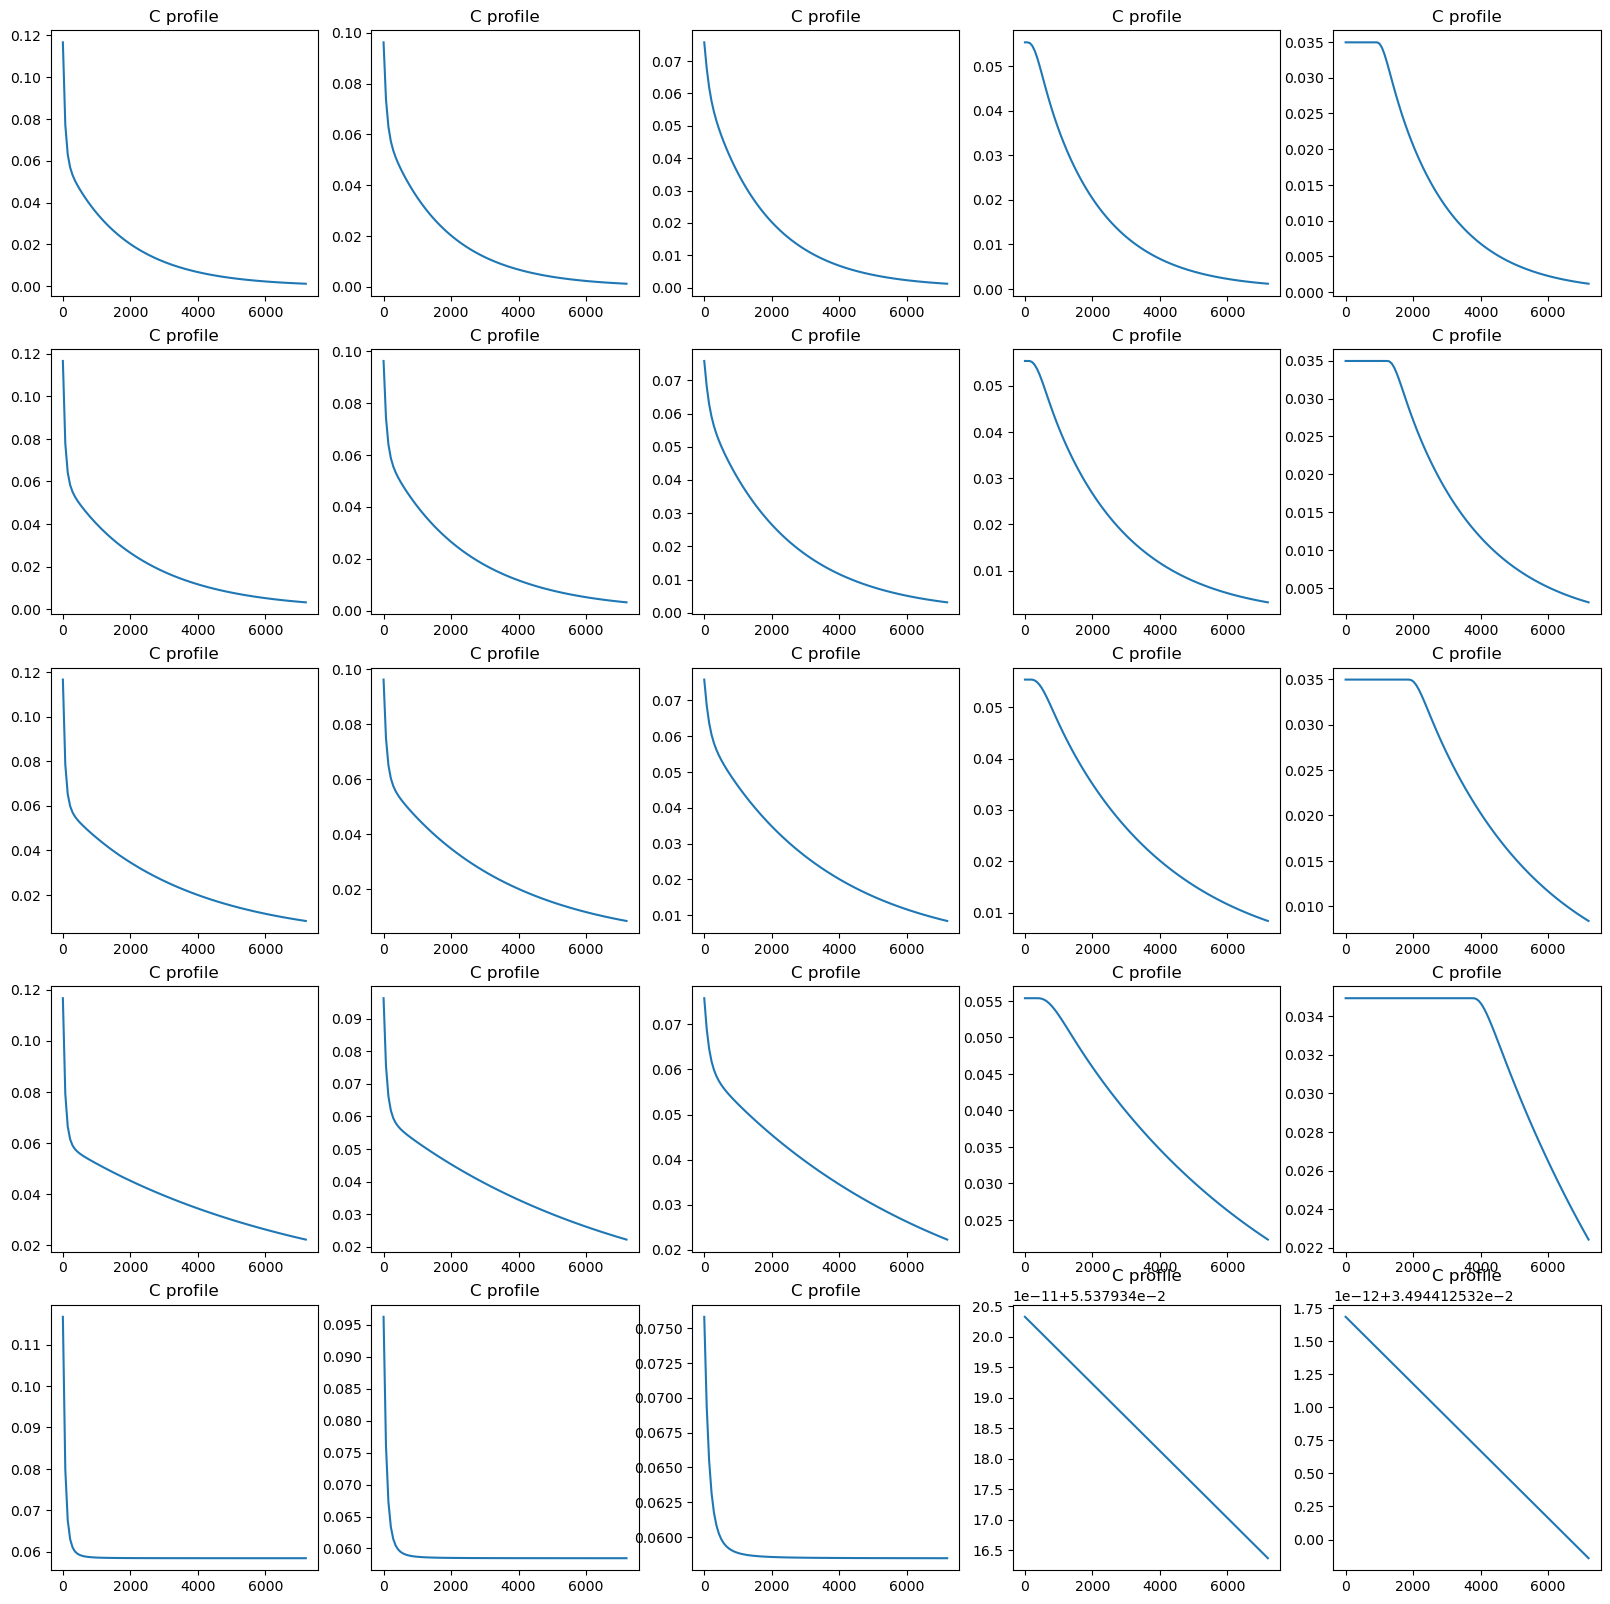

In [41]:
# (Optional) Inspect data from prior experiments - C profiles

fig_size = int(np.ceil(np.sqrt(len(Heatmap_expts))))
fig = plt.figure(figsize=(fig_size*4, fig_size*4))

for i in range(len(Heatmap_expts)):
    x = sim_exp_data_frames[i]["time"]
    y = sim_exp_data_frames[i]["avg_volume"]
    y = sim_exp_data_frames[i]["C"]
    plt.subplot(fig_size, fig_size, i+1)
    plt.plot(x,y)
    # plt.title("\mu_43")
    plt.title("C profile")

print(Selection_Pool)


In [ ]:
# (Optional) Inspect data from prior experiments - C profiles

fig_size = int(np.ceil(np.sqrt(np.shape(list_of_exp_data_frames)[0])))
fig = plt.figure(figsize=(fig_size*3, fig_size*3))

for i in range(np.shape(list_of_exp_data_frames)[0]):
    x = list_of_exp_data_frames[i]["time"]
    y = list_of_exp_data_frames[i]["C"]
    plt.subplot(fig_size, fig_size, i+1)
    plt.plot(x,y)
    plt.title("C profile")


In [42]:
print(Heatmap_FIM)

[array([[470.85935415, 148.11055741],
       [148.11055741,  46.71299312]]), array([[470.85935415, 148.11055741],
       [148.11055741,  46.71299312]]), array([[470.85935415, 148.11055741],
       [148.11055741,  46.71299312]]), array([[470.85935415, 148.11055741],
       [148.11055741,  46.71299312]]), array([[470.85935415, 148.11055741],
       [148.11055741,  46.71299312]]), array([[470.85935415, 148.11055741],
       [148.11055741,  46.71299312]]), array([[470.85935415, 148.11055741],
       [148.11055741,  46.71299312]]), array([[470.85935415, 148.11055741],
       [148.11055741,  46.71299312]]), array([[470.85935415, 148.11055741],
       [148.11055741,  46.71299312]]), array([[470.85935415, 148.11055741],
       [148.11055741,  46.71299312]]), array([[470.85935415, 148.11055741],
       [148.11055741,  46.71299312]]), array([[470.85935415, 148.11055741],
       [148.11055741,  46.71299312]]), array([[470.85935415, 148.11055741],
       [148.11055741,  46.71299312]]), array([[470

In [ ]:
cov_sim   = [] # Create list: covariance matrix for each parameter estimation
trace_sim = [] # Create list: det(cov) for each cov. matrix

for i in range(len(Heatmap_FIM)):
    cov_sim.append(np.linalg.inv(Heatmap))       # Get covariance matrix of initial parameter set estimation
    trace_sim.append(scipy.linalg.det(cov_est[0]))    # Get det(cov) which indicates volume of combined confidence ellipsoid
    FIM_store.append(result.FIM)